# Imports and some useful functions

In [2]:
from importlib import reload

In [5]:
import modelling_functions
reload(modelling_functions)
reload(yoon_model_functions_pooled_INTEGRATION)

<module 'yoon_model_functions_pooled_INTEGRATION' from '/mnt/c/Users/faust/Dropbox/marieCurie/PlauDeNotes/yoon_model_functions_pooled_INTEGRATION.py'>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import seaborn as sns

import pymc as pm
import pytensor as aesara
import pytensor.tensor as at
import arviz as az

from modelling_functions import (
    normalize, 
    masked_mean,
    get_data,
    Integrate
)

import yoon_model_functions_pooled
import yoon_model_functions_hierarchical
import my_model_functions
import yoon_model_functions_pooled_INTEGRATION

# Get and plot Yoon's data

In [7]:
dt, utt_i, goal_id, goals, dt_meaning = get_data()

/mnt/c/Users/faust/Dropbox/marieCurie/PlauDeNotes/modelling_functions.py:61: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dt.loc[:,'true_state'] = dt['true_state'].str.lstrip('heart').astype(int)


## Basic plotting

In [10]:
dt_social = dt[dt['goal'] == 'social']
dt_social = dt_social.drop(columns=['goal', 'item'])
dt_social = dt_social.reset_index(drop=True)

In [11]:
dt

trial          item         goal  true_state positivity utterance   id  \
0         1          song  informative           3     no_neg   amazing    0   
1         2      painting  informative           2     no_neg      good    0   
2         3          cake  informative           0     no_neg  terrible    0   
3         4          film  informative           1     no_neg       bad    0   
4         5       recital       social           3     no_neg   amazing    0   
...     ...           ...          ...         ...        ...       ...  ...   
2431      8       recital         both           1        neg  terrible  202   
2432      9        cookie       social           3     no_neg   amazing  202   
2433     10  presentation       social           0        neg       bad  202   
2434     11           app       social           2        neg       bad  202   
2435     12          song       social           1        neg  terrible  202   

     utterance_full  utterance_index  
0           amazing                3  
1              good                2  
2          terrible                0  
3               bad                1  
4           amazing                3  
...             ...              ...  
2431   not terrible                4  
2432        amazing                3  
2433        not bad                5  
2434        not bad                5  
2435   not terrible                4  

[2436 rows x 9 columns]

Each participant is asked to be kind in 4 trials

<AxesSubplot:>

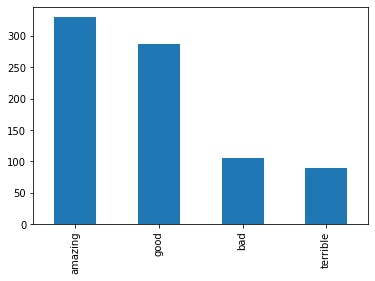

In [10]:
%matplotlib inline
dt_social['utterance'].value_counts().plot.bar()

In [11]:
df_plotting_kind = (
    dt_social
    .groupby(['positivity', 'true_state'])
    ['utterance']
    .value_counts()
    .fillna(0)
    .to_frame()
    .rename(columns={'utterance': 'count'})
    .unstack().fillna(0)
    .stack()
    .reset_index()
) 

In [19]:
df_plotting_kind.groupby('true_state').sum()

count
true_state       
0           203.0
1           203.0
2           203.0
3           203.0

In [20]:
df_plotting_kind.loc[:, 'count'] = df_plotting_kind['count'] / 203

[]

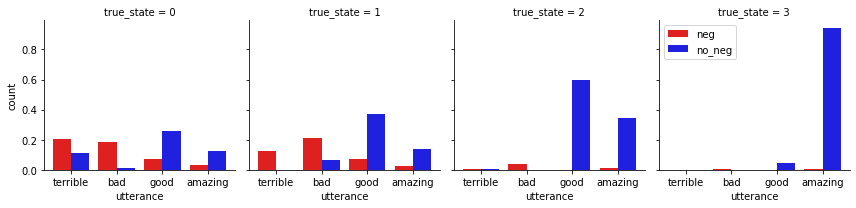

In [21]:
g = sns.FacetGrid(
    data=df_plotting_kind,
    col='true_state',
)

g.map_dataframe(
    sns.barplot,
    x='utterance',
    y='count',
    hue='positivity',
    order=['terrible', 'bad', 'good', 'amazing'],
    palette={'neg':'r', 'no_neg':'b'},
)

# map(lambda ax: ax.set_xticks(np.arange(4), labels=['terrible', 'bad', 'good', 'amazing']), g.axes)

plt.legend()
plt.plot()

Find the correlations in the data: are participants that produce one signal for 0 hearts more likely to produce another one for 1 heart?

In [22]:
df_transitions = (
    dt
    .loc[dt['true_state']<=1]
    .groupby(['goal', 'id'])
    ['utterance_full']
    .transform(lambda x: ' -> '.join(x))
    .iloc[::2]
    .reset_index(drop=True)
    .to_frame()
)

df_transitions.loc[:,'goal'] = (
    dt
    .loc[dt['true_state']<=1,'goal']
    .iloc[::2]
    .reset_index(drop=True)
)

df_transitions.loc[:,'id'] = (
    dt
    .loc[dt['true_state']<=1,'id']
    .iloc[::2]
    .reset_index(drop=True)
)

df_transitions = (
    df_transitions
    .groupby(['goal','utterance_full'])
    .count()
    .reset_index()
    .rename(columns={'id':'counts'})
    .sort_values('counts')
)

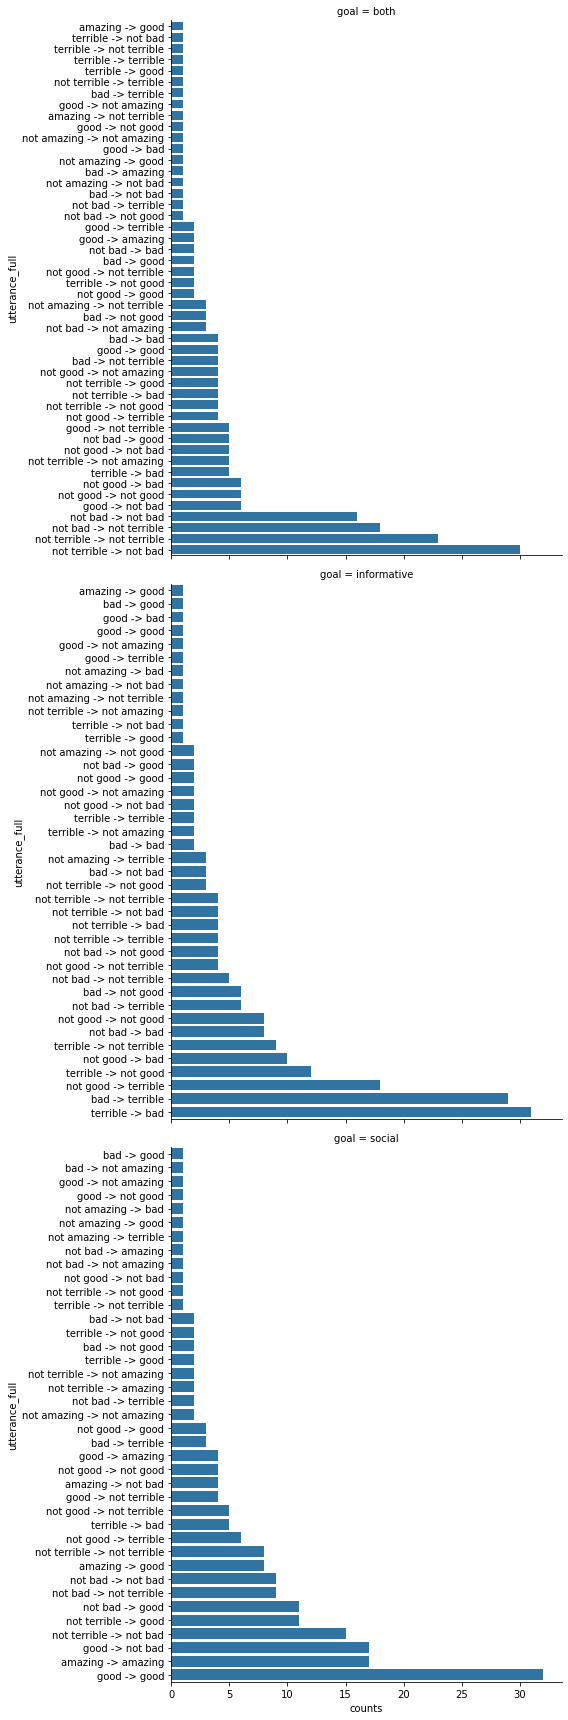

In [595]:
%matplotlib inline

g = sns.FacetGrid(
    data=df_transitions,
    row='goal',
    height=8,
    aspect=1,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    y='utterance_full',
    x='counts',
    orient='h'
)

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(rotation=90)
    
g.savefig('transition_counts.png', dpi=300)

In [59]:
def f(df):
    df = df.sort_values('true_state')
    df_ = pd.Series(
        df.utterance_full.ravel(),
        index=df.true_state.ravel()
    )
    return df_

In [162]:
choices_series = (
    dt
    .groupby(['id', 'goal'])
    .apply(f)
    .reset_index()
)

choices_series.loc[:,0:] = choices_series.loc[:,0:].apply(
    lambda x: x.str.pad(width=12, side='right', fillchar=' ')
)

choices_concatenated = (
    choices_series[0]
    .str
    .cat(choices_series.loc[:,1:], sep=' > ')
    .to_frame(name='choices')
    .assign(goal=choices_series.goal)
    .value_counts()
    .to_frame('counts')
    .reset_index()
)

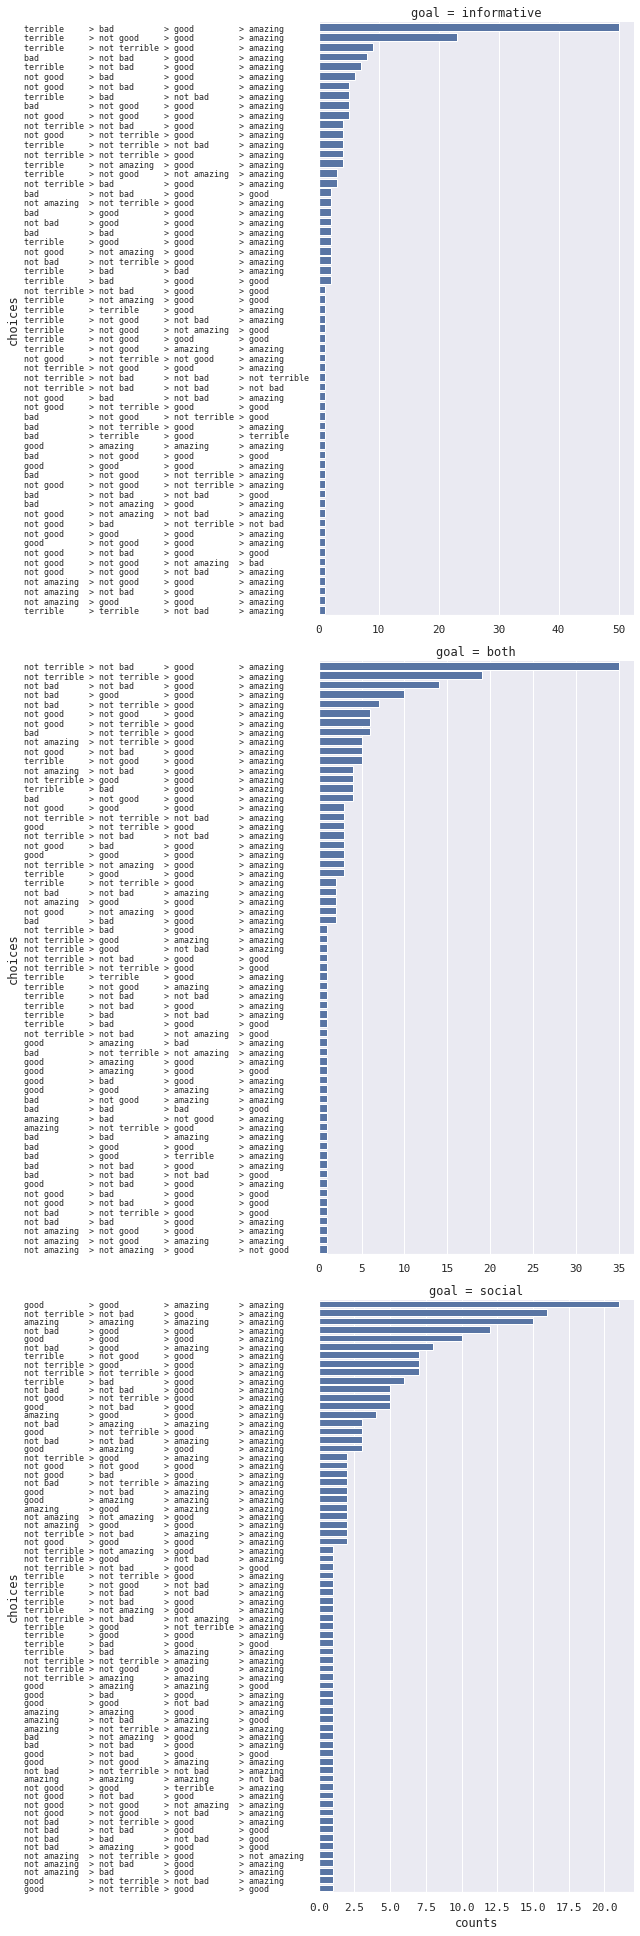

In [179]:
%matplotlib inline
with sns.plotting_context(rc={'font':'monospace', 'ytick.labelsize': 'small'}):
    
    g = sns.FacetGrid(
        data=choices_concatenated,
        row='goal',
        sharex=False,
        sharey=False,
        height=9,
        aspect=1,
    )

    g.map_dataframe(
        sns.barplot,
        y='choices',
        x='counts',
        orient='h'
    )

## Sankey plots

In [180]:
from pySankey import sankey

In [182]:
choices_series

id         goal             0             1             2             3
0      0         both  not terrible  not bad       good          amazing     
1      0  informative  terrible      bad           good          amazing     
2      0       social  not bad       good          amazing       amazing     
3      1         both  not bad       good          good          amazing     
4      1  informative  bad           not bad       good          amazing     
..   ...          ...           ...           ...           ...           ...
604  201  informative  terrible      bad           good          amazing     
605  201       social  terrible      bad           good          amazing     
606  202         both  not amazing   not terrible  good          amazing     
607  202  informative  not good      not good      good          amazing     
608  202       social  not bad       not terrible  not bad       amazing     

[609 rows x 6 columns]

Empty DataFrame
Columns: []
Index: []

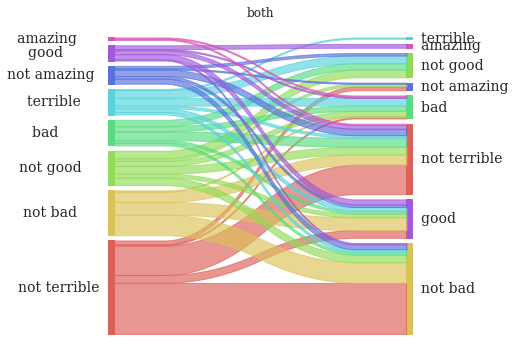

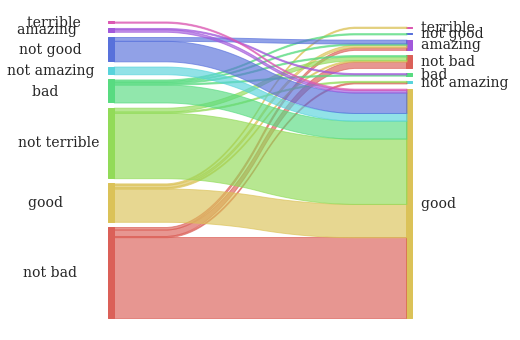

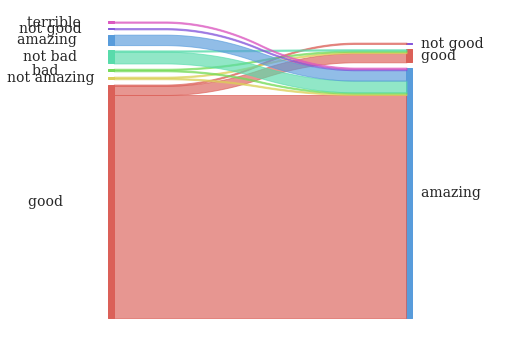

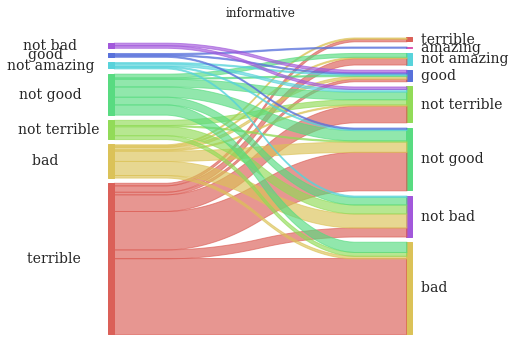

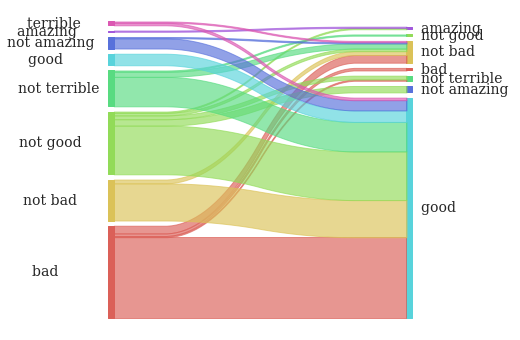

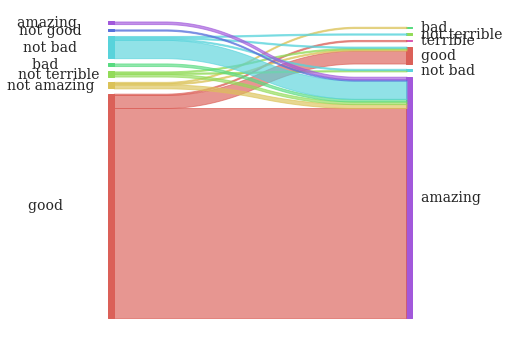

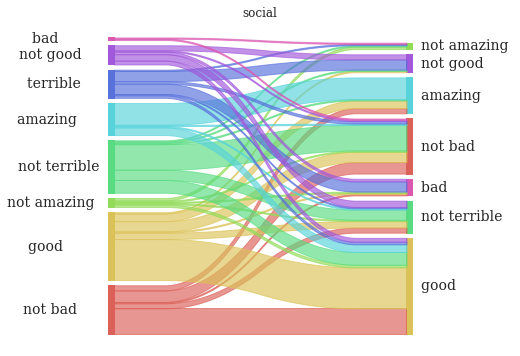

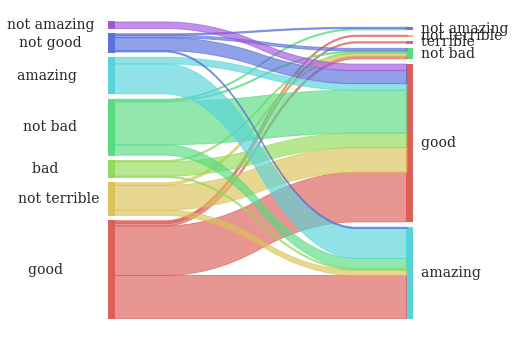

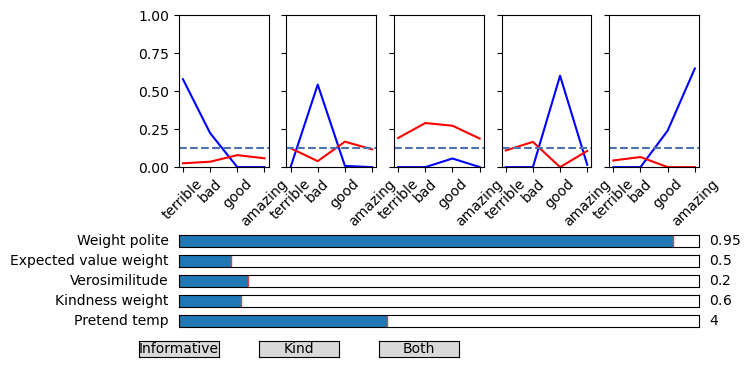

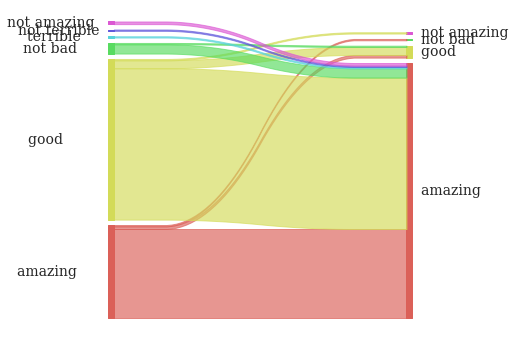

In [210]:
def g_f(data, **kws):
        
    plt.sca(axes[0])
    sankey.sankey(
        data.loc[:,0],
        data.loc[:,1],
    )
    plt.title(data['goal'].iloc[0])
    
    plt.sca(axes[1])
    sankey.sankey(
        data.loc[:,1],
        data.loc[:,2],
    )
    
    plt.sca(axes[2])
    sankey.sankey(
        data.loc[:,2],
        data.loc[:,3],
    )
    

(
    choices_series
    .groupby('goal')
    .apply(g_f)
)

# Yoon's model in numpy

## Description

Possible instructions:
- Be informative: "give accurate and informative feedback"
- Be kind: "make the listener feel good"
- Both

From the supplementary material to the Yoon paper (equation 4 has a typo: it should also condition on $\phi$):

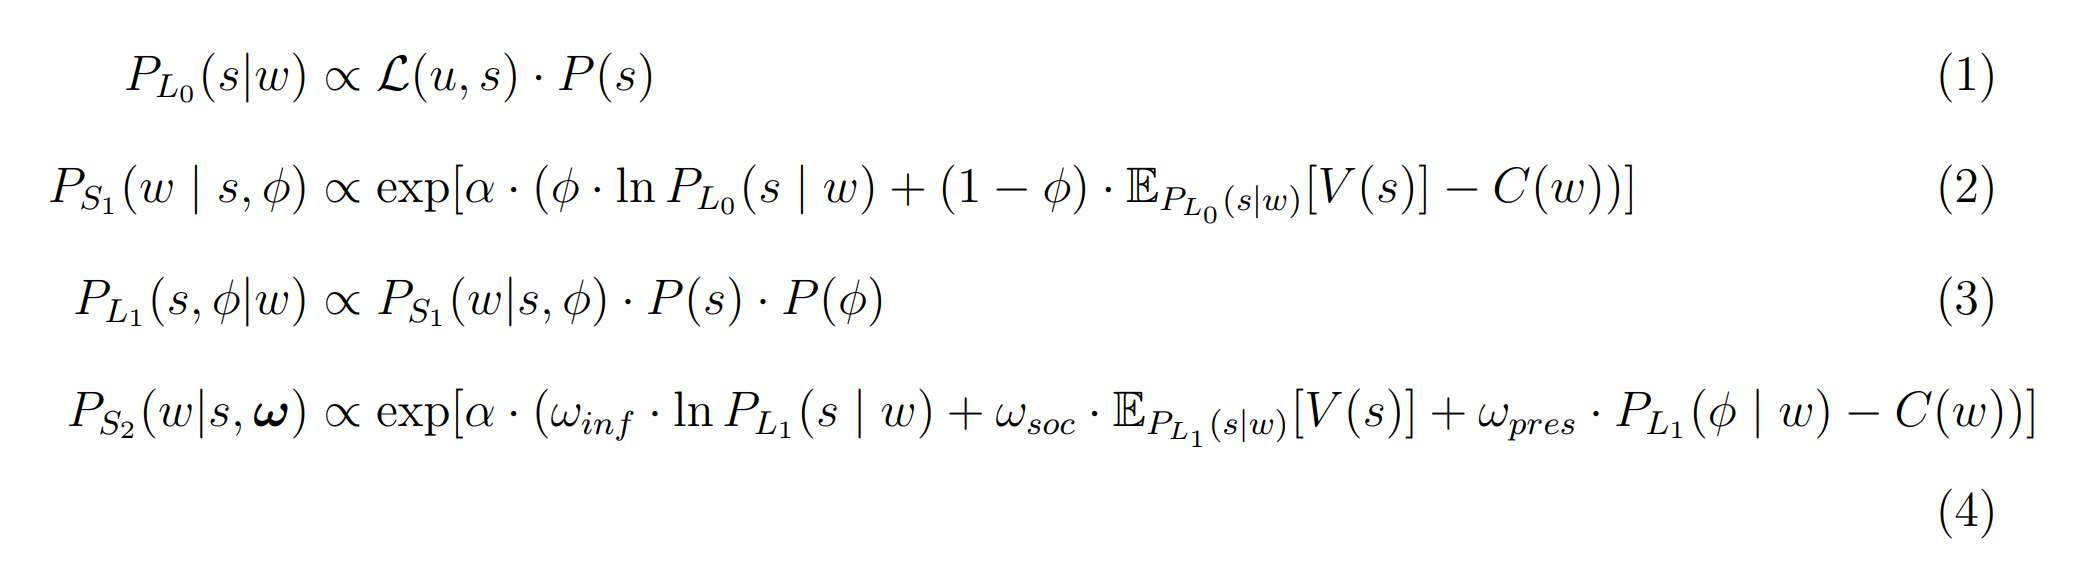

\begin{align}
P_{L_0} (s \mid w) 
&\propto \mathcal{L}(u, s) P(s) \\
P_{S_1} (w \mid s, \phi) 
&\propto \exp \left[
    \alpha \left(
        \phi \ln P_{L_0} (s \mid w) + 
        (1-\phi) \mathbb{E}_{P_{L_0}(s \mid w)} [V(s)]
        - C(w)
    \right)
\right] \\
P_{L_1} (s, \phi \mid w) 
&\propto P_{S_1} (w \mid s, \phi) P(s) P(\phi) \\
P_{S_2} (w \mid s, \omega, \phi) 
&\propto \exp \left[
    \alpha \left(
        \omega_{\text{inf}} \ln P_{L_1} (s\mid w)
        + \omega_{\text{soc}} \mathbb{E}_{P_{L_1}(s \mid w) [V(s)] }
        + \omega_{\text{pres}} P_{L_1} (\phi \mid w)
        - C(w)
    \right)
\right]
\end{align}

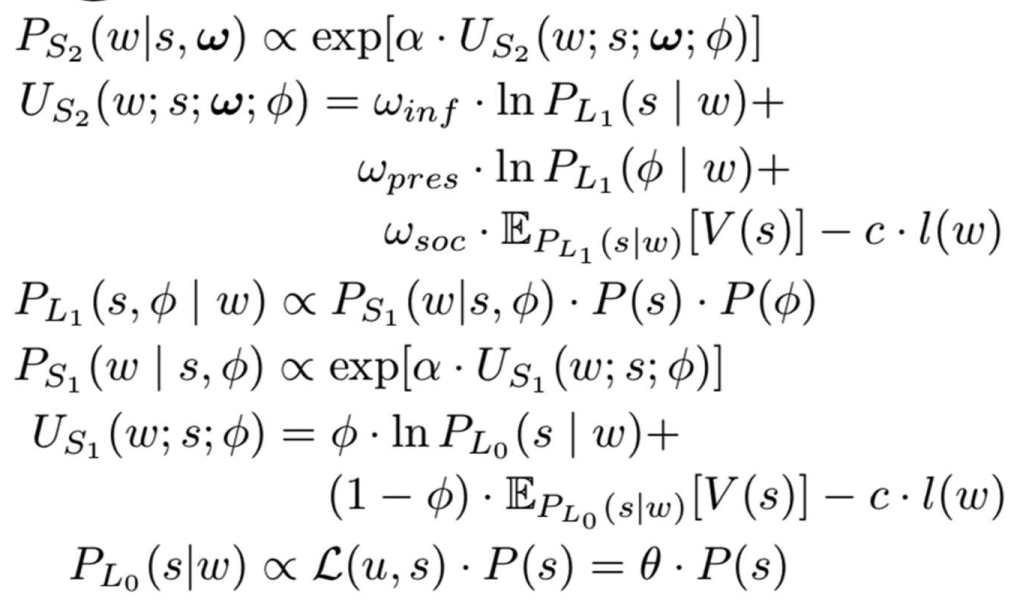

\begin{align}
P_{L_1} (s, \phi \mid w) 
&= \frac{
    P_{S_1} (w \mid s, \phi) P_{S_1} (s) P_{S_1} (\phi) 
}{
    P_{S_1} (w)
} \\
&= \frac{
    P_{S_1} (w \mid s, \phi) P_{S_1} (s) P_{S_1} (\phi) 
}{
    \sum_s \int_0^1 P_{S_1} (w \mid s, \phi) P_{S_1} (s) P_{S_1} (\phi) d\phi
} \\
&= \frac{
    P_{S_1} (w \mid s, \phi)
}{
    \sum_s \int_0^1 P_{S_1} (w \mid s, \phi) d\phi
} \\
\end{align}

Suppose we wanted to calculate $S_2$ explicitly. Then we'd have to calculate:

\begin{align}
P_{L_1} (s \mid w) 
&= \int_0^1 P_{L_1} (s, \phi \mid w) d\phi \\
&= \int_0^1 \frac{
    P_{S_1} (w \mid s, \phi) P_{S_1} (s) P_{S_1} (\phi) 
}{
    P_{S_1} (w)
} d\phi
\\
&= 
\frac{1}{\sum_s \int_0^1 P_{S_1} (w \mid s, \phi) d\phi} 
\int_0^1 P_{S_1} (w \mid s, \phi) d\phi  
\end{align}

In practice, this means that I need to calculate the vector $\int_0^1 P_{L_1} (s, \phi \mid w) d\phi$ for each utterance $w$, and then:
- Normalize by utterance to get $P_{L_1} (s \mid w)$
- Sum across signals to get normalization factor for $P_{L_1} (s, \phi \mid w)$, namely $P_{S_1} (w)$

The best approach is to write an aesara Op object that encodes the calculation of $\int_0^1 P_{L_1} (s, \phi \mid w) d\phi$ as well as its gradients wrt all the input variables: $\theta$, $c$, $\alpha$ (since states and utterances are fixed).

Now, the evaluation of the integral is easy: it can be done with scipy's quad. The gradients we can get by Leibniz' integral rule:

$$
\frac{d}{d c} \int_0^1 P_{L_1} (s, \phi \mid w, c, \alpha, \theta) d\phi = 
\int_0^1 \frac{\partial}{\partial c} P_{L_1} (s, \phi \mid w, c, \alpha, \theta) d\phi
$$

$$
\frac{d}{d \alpha} \int_0^1 P_{L_1} (s, \phi \mid w, c, \alpha, \theta) d\phi = 
\int_0^1 \frac{\partial}{\partial \alpha} P_{L_1} (s, \phi \mid w, c, \alpha, \theta) d\phi
$$

$$
\frac{\partial}{\partial \theta} \int_0^1 P_{L_1} (s, \phi \mid w, c, \alpha, \theta) d\phi
$$

This last one we can calculate pointwise for each value of $\theta$ still applying Leibniz' rule, since the components of $\theta$ are independent of each other (they don't lie on a lower dimensional manifold).

We can attempt to integrate it analytically:

So we need to integrate this wrt $\phi$:

$$
P_{S_1} (w \mid s, \phi) = 
\frac{1}{P_{S_1} (s, \phi)}
\exp \left( 
    \alpha \phi \ln P_{L_0} (s \mid w)
    + \alpha (1-\phi) \mathbb{E}[V(s)]
    - \alpha C(w)
\right)
$$

The second part alone would be easy to integrate:

$$
e^{
\alpha \phi \ln P_{L_0} (s \mid w)
+ \alpha \mathbb{E}[V(s)]
- \alpha \phi \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

$$
e^{
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
+ \alpha \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

$$
e^{ 
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
$$

Using:

$$
\int_0^1 e^{a \phi} d\phi = \dfrac{\mathrm{e}^a}{a}-\dfrac{1}{a}
$$

As the following integral:

$$
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
\int_0^1
e^{ 
\phi \alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
d\phi
= \\
e^{
\alpha \mathbb{E}[V(s)]
}
e^{
\alpha C(w)
}
\left(
\dfrac{
\mathrm{e}^{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
}{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}-\dfrac{1}{
\alpha \left(
    \ln P_{L_0} (s \mid w)
    - \mathbb{E}[V(s)]
\right)
}
\right)
$$

But unfortunately the expressions to integrate also contains $\frac{1}{P_{S_1} (s, \phi)}$, where:

$$
P_{S_1} (s, \phi) 
= \sum_{w} P_{S_1} (w, s, \phi) 
= \sum_{w} 
e^{
\alpha \phi \ln P_{L_0} (s \mid w)
+ \alpha \mathbb{E}[V(s)]
- \alpha \phi \mathbb{E}[V(s)]
- \alpha C(w)
}
$$

So instead of integration I just do grid integration for the phi parameter. It seems to give results that are pretty close to the ones in the paper.

## Implementation

In [300]:
# using a grid approximation
# for phi
phis = np.linspace(0,1,100)

us = [
    'terrible',
    'bad',
    'good',
    'amazing',
    'not terrible',
    'not bad',
    'not good',
    'not amazing'
]

# costs taken from https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
costs = np.array([
    1,
    1,
    1,
    1,
    2,
    2,
    2,
    2
])

# literal semantic compatibility
# shape: (utterances, states)
# Copied from 
# https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
L = np.array([
    [0.961, 0.627, 0.039, 0.039],
    [0.980, 0.882, 0.039, 0.020],
    [0.001, 0.020, 0.941, 0.999],
    [0.001, 0.001, 0.216, 0.980],
    [0.001, 0.353, 0.980, 0.863],
    [0.020, 0.157, 0.999, 0.902],
    [0.961, 0.863, 0.039, 0.020],
    [0.961, 0.980, 0.627, 0.039]
])

# goal weights
# [informational, prosocial, presentational]
omega = normalize(
    np.array([1,1,1]),
    0
)

values = np.array([0, 1, 2, 3])

# https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
alpha = 2.5

In [293]:
L0 = normalize(L,1)

# expected value given each utterance
# NOTE: This only works if L is not
# exactly 0 anywhere!
exp_values = np.mean(
    values*L0,
    1
)

# p(u | s, phi)
# where phi is essentially 
# a politeness weight
S1 = normalize(
    np.exp(alpha*(
        # informational component
        + phis[:,None,None]*np.log(L0)
        # social component
        + (1-phis)[:,None,None]*exp_values[:,None]
        - costs[:,None]
    )),
    axis=(1)
)

# Prob of state and phi
# given utterance
L1 = normalize(
    S1,
    (0,2)
)

# informativity of utterances given state
# with utterances produced by L1
u_inf = np.log(L1)

L1_s_given_w = L1.sum(0)

# expected value of state
# given utterance as produced by L1
u_soc = np.mean(
    values*L1_s_given_w,
    1
)

# marginalize across states
u_pres = S1.sum(2)

# shape (3, value of phi, utterance, state)
utilities = np.stack(np.broadcast_arrays(
    u_inf,
    u_soc[None,:,None],
    u_pres[:,:,None]
))

util_total = (
    (
        omega[:,None,None,None] 
        # The normalization is not in the paper
        # But it is in the code!
        # in https://github.com/ejyoon/polite_speaker/blob/master/02_analysis/02_script/03_understanding-prsa.Rmd
        * utilities
    )
    .sum(0) 
    - costs[:,None]
)

# prob of utterance given state
# Shape: (phi, utterance, state)
S2 = normalize(
    np.exp(alpha*util_total), 
    1
)

In [270]:
S1.shape

(100, 8, 4)

In [271]:
S1.sum(1)[:10]

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [272]:
S2.shape

(100, 8, 4)

In [273]:
S2[10]

array([[0.19973639, 0.15309846, 0.04482383, 0.03819354],
       [0.19437864, 0.1594263 , 0.04344212, 0.03216309],
       [0.21964189, 0.34597241, 0.40867663, 0.35263634],
       [0.34626704, 0.29036996, 0.47269119, 0.55369186],
       [0.00604101, 0.01740998, 0.01133668, 0.00940475],
       [0.01188614, 0.01537785, 0.01192301, 0.00994333],
       [0.00993599, 0.00814557, 0.00222978, 0.00165086],
       [0.01211291, 0.01019949, 0.00487675, 0.00231623]])

[[<matplotlib.lines.Line2D at 0x7f099f65a6e0>,

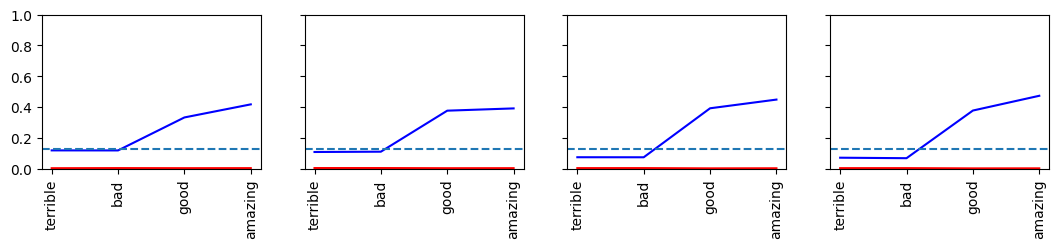

In [295]:
plot_s1(S2[10])

## Reproduce Figure 2

In [320]:
%matplotlib inline

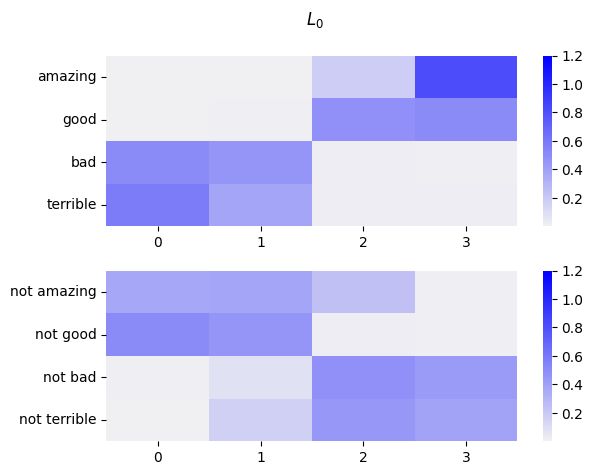

In [241]:
L0_df = pd.DataFrame(
    L0,
    index=us
)

fig, (ax1, ax2) = plt.subplots(2,1)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    L0_df.iloc[3::-1],
    ax=ax1,
    cmap=cmap,
    vmax=1.2
)

sns.heatmap(
    L0_df[:3:-1],
    ax=ax2,
    cmap=cmap,
    vmax=1.2
)

fig.suptitle(r'$L_0$')
plt.tight_layout()
plt.show()

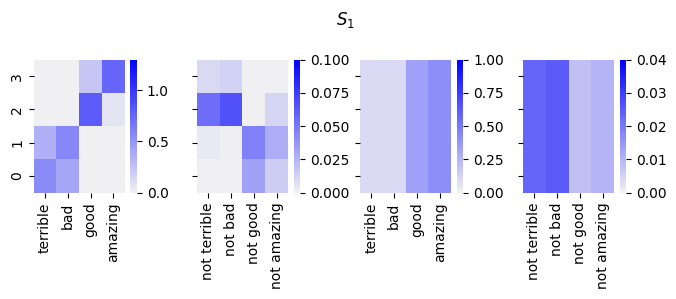

In [242]:
S1_df_info = pd.DataFrame(
    S1[-1].T,
    columns=us
)

S1_df_social = pd.DataFrame(
    S1[0].T,
    columns=us
)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1,4, 
    figsize=(7,3),
    sharey=True
)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    S1_df_info.iloc[::-1,:4],
    ax=ax1,
    cmap=cmap,
    vmin=0,
    vmax=1.3
)

sns.heatmap(
    S1_df_info.iloc[::-1,4:],
    ax=ax2,
    cmap=cmap,
    vmin=0,
    vmax=0.1
)

sns.heatmap(
    S1_df_social.iloc[::-1,:4],
    ax=ax3,
    cmap=cmap,
    vmin=0,
    vmax=1
)

sns.heatmap(
    S1_df_social.iloc[::-1,4:],
    ax=ax4,
    cmap=cmap,
    vmin=0,
    vmax=0.04
)

fig.suptitle(r'$S_1$')

plt.tight_layout()
plt.show()

In [243]:
# bin the phi parameter into 5 bins
# and take means, to get clsoe to the figure
L1_toplot = np.stack(np.split(L1, 5)).mean(1).swapaxes(0,1)

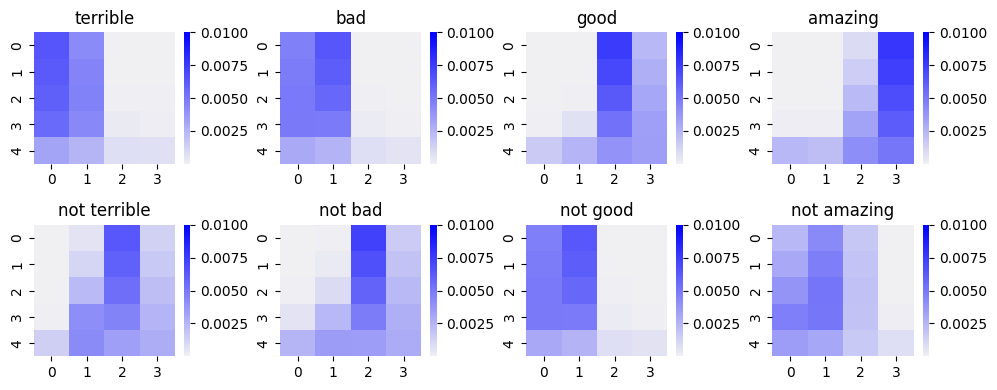

In [244]:
fig, axes = plt.subplots(2,4, figsize=(10,4))
cmap = sns.color_palette("light:b", as_cmap=True)

for i, (ax, subdf, u) in enumerate(zip(axes.flatten(), L1_toplot, us)):
    sns.heatmap(
        subdf[::-1], 
        cmap=cmap,
        ax=ax,
        vmax=0.01
    )
    ax.set_title(u)
    
plt.tight_layout()

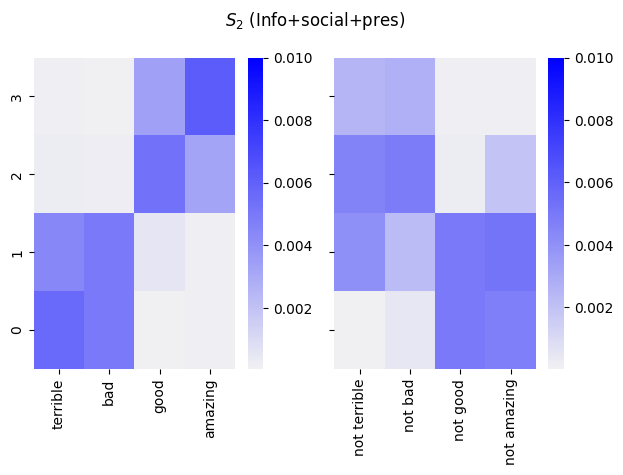

In [245]:
uinf_df = pd.DataFrame(
    # value is exponentiated in plotted figure
    # not sure why!
    np.exp(u_inf)[30],
    index=us
).T

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

cmap = sns.color_palette("light:b", as_cmap=True)

# cmap.reversed()

sns.heatmap(
    uinf_df.iloc[::-1,:4],
    ax=ax1,
    cmap=cmap,
    vmax=0.01
)

sns.heatmap(
    uinf_df.iloc[::-1,4:],
    ax=ax2,
    cmap=cmap,
    vmax=0.01
)

fig.suptitle(r'$S_2$ (Info+social+pres)')

plt.tight_layout()
plt.show()

# Fit Yoon's model to data

## With integration function - Non-hierarchical 

In [8]:
### Example of usage

y_obs = np.array([8.3, 8.0, 7.8])
start = aesara.shared(1.)
stop = aesara.shared(2.)

with pm.Model() as basic_model:
    
    a = pm.Uniform('a', 1.5, 3.5)
    b = pm.Uniform(
        'b', 
        4., 6., 
        shape=(3)
    )

    # Define the function to integrate in plain pytensor
    t = at.dscalar('t')
    t.tag.test_value = np.zeros(())
    
    a_ = at.dscalar('a_')
    a_.tag.test_value = np.ones(())*2.
    
    b_ = at.dvector('b_')
    b_.tag.test_value = np.ones((3))*5.
    # b_ = at.dscalar('b_')
    # b_.tag.test_value = np.ones(())*5.
    
    func = t**a_ + b_
    integrate = Integrate(
        # Function we're integrating
        func, 
        # variable we're integrating
        t, 
        # other variables
        a_, b_
    )

    # Now we plug in the values from the model.
    # The `a_` and `b_` from above corresponds 
    # to the `a` and `b` here.
    mu = integrate(
        start, 
        stop, 
        a, 
        b
    )
    y = pm.Normal(
        'y', 
        mu=mu, 
        sigma=0.4, 
        observed=y_obs
    )

In [9]:
func.ndim

1

In [10]:
with basic_model:
    ppc = pm.sample_prior_predictive()

Sampling: [a, b, y]


In [10]:
with basic_model:
    trace = pm.sample(
        1500, 
        tune=500, 
        cores=2, 
        chains=2,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 172 seconds.


In [11]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Testing function

In [147]:
import yoon_model_functions_pooled_INTEGRATION as yoon_int

In [148]:
testvalues = {
    'p': np.array(0.2),
    'alpha': np.array(2),
    'costs': np.array([1,1,1,1,2,2,2,2]),
    'L0': np.array([
        [0.961, 0.627, 0.039, 0.039],
        [0.980, 0.882, 0.039, 0.020],
        [0.001, 0.020, 0.941, 0.999],
        [0.001, 0.001, 0.216, 0.980],
        [0.001, 0.353, 0.980, 0.863],
        [0.020, 0.157, 0.999, 0.902],
        [0.961, 0.863, 0.039, 0.020],
        [0.961, 0.980, 0.627, 0.039]
    ]),
    'exp_values': np.array([
        0.2055 , 0.255  , 1.22475, 0.84325, 
        1.2255 , 1.21525, 0.25025, 0.58775
    ])
}   

In [149]:
with pm.Model() as integrate_test_model:
    
    L = pm.Uniform(
        'L',
        lower=0,
        upper=1,
        shape=(8,4)
    )
    
    negative_cost = pm.Uniform(
        'c',
        lower=1,
        upper=10
    )

    costs = at.concatenate((
        at.ones(4),
        at.repeat(negative_cost,4)
    ))

    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0,
        upper=20
    ) 

    values = np.array([0, 1, 2, 3])

    # dimensions (utterance, state)
    L0 = yoon_int.normalize(L,1)

    # expected value given each utterance
    # Shape (utterance)
    # NOTE: This only works if L is not
    # exactly 0 anywhere!
    exp_values = at.mean(
        values*L0,
        axis=1
    )
    
    phi_ = at.dscalar('p')
    phi_.tag.test_value = testvalues['p']
    alpha_ = at.dscalar('alpha')
    alpha_.tag.test_value = testvalues['alpha']
    costs_ = at.dvector('costs')
    costs_.tag.test_value = testvalues['costs']
    L0_ = at.dmatrix('L0')
    L0_.tag.test_value = testvalues['L0']
    exp_values_ = at.dvector('exp_values')
    exp_values_.tag.test_value = testvalues['exp_values']

    # dims (goal condition, utterance, state)
    # Define the function to integrate!
    S1_ = yoon_int.yoon_S1(
        phi_, 
        alpha_, 
        costs_, 
        L0_, 
        exp_values_
    )

    integrate = modelling_functions.Integrate(
        # expression we're integrating
        S1_, 
        # variable wrt which we're integrating
        # NOTE: phi must be a scalar!
        phi_, 
        # other variables
        alpha_, 
        costs_, 
        L0_, 
        exp_values_
    )

    start = aesara.shared(0., name='start')
    stop = aesara.shared(1., name='stop')
    # Now we plug in the values from the model.
    # The result is S1 with phi integrated out.
    # Dims: (goal condition, utterance, state)
    S1_integrated_phi = integrate(
        start, 
        stop, 
        # other variables
        alpha, 
        costs, 
        L0, 
        exp_values
    )

In [104]:
evaldict = {
    phi_: testvalues['p'],
    alpha_: testvalues['alpha'],
    costs_: testvalues['costs'],
    L0_: testvalues['L0'],
    exp_values_: testvalues['exp_values']
}

In [105]:
phi_.ndim

1

In [153]:
with integrate_test_model:
    ppc = pm.sample_prior_predictive()

Sampling: [L, alpha, c]


In [71]:
ppc

Inference data with groups:
	> prior

In [154]:
with integrate_test_model:
    trace_test = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, c, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [ ]:
trace_test

Inference data with groups:
	> posterior
	> sample_stats

### Fit data

In [12]:
yoon_model_pooled_int = yoon_model_functions_pooled_INTEGRATION.factory_yoon_model(
    dt,
    dt_meaning
)

S1_integrated_phi:  Reshape{2}.0
S1_integrated_phi ndim:  2
U soc:  [0.12842751 0.4138766  0.49304585 0.47501599 0.42638369 0.21609187
 0.06351815 0.37028638]
U soc shape:  (8,)
U inf:  [[-0.48311388 -1.22621543 -3.01778403 -3.1983364 ]
 [-1.70144621 -1.56722149 -0.96761831 -1.47416662]
 [-3.0915562  -0.85810178 -3.13290895 -0.71946674]
 [-1.96667498 -2.98423197 -0.54642621 -1.46756973]
 [-1.04383078 -2.88563568 -2.06737969 -0.76451306]
 [-0.53454954 -2.4240236  -1.60592452 -2.08105594]
 [-0.24282135 -1.68210757 -3.87620794 -4.72423724]
 [-1.20244541 -2.02522278 -1.03973065 -1.54165266]]
U inf shape:  (8, 4)
U pres:  [[ 0.1667068  -0.16137519  0.00520817 -0.0807082  -0.05985036  0.06526154
   0.18667773 -0.11632956]
 [ 0.16017552 -0.14830567  0.00209141 -0.07793092 -0.05381979  0.07071297
   0.1673834  -0.10280529]
 [ 0.1874506  -0.20575678  0.01553884 -0.08936022 -0.08001808  0.0451159
   0.25051877 -0.16286988]]
U pres shape:  (3, 8)


In [237]:
with yoon_model_pooled_int:
    pm.sample_prior_predictive()

Sampling: [L, L_observed, alpha, c, chosen, omega, phi]


In [13]:
with yoon_model_pooled_int:
    yoon_pooled_int_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, c, alpha, omega, phi]


ValueError: Not enough samples to build a trace.

## Non-hierarchical

In [297]:
yoon_model = yoon_model_functions_pooled.factory_yoon_model(
    dt,
    dt_meaning
)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [21]:
yoon_trace = az.from_netcdf(
    'traces/yoon_trace_nonhierarchical.cdf'
)

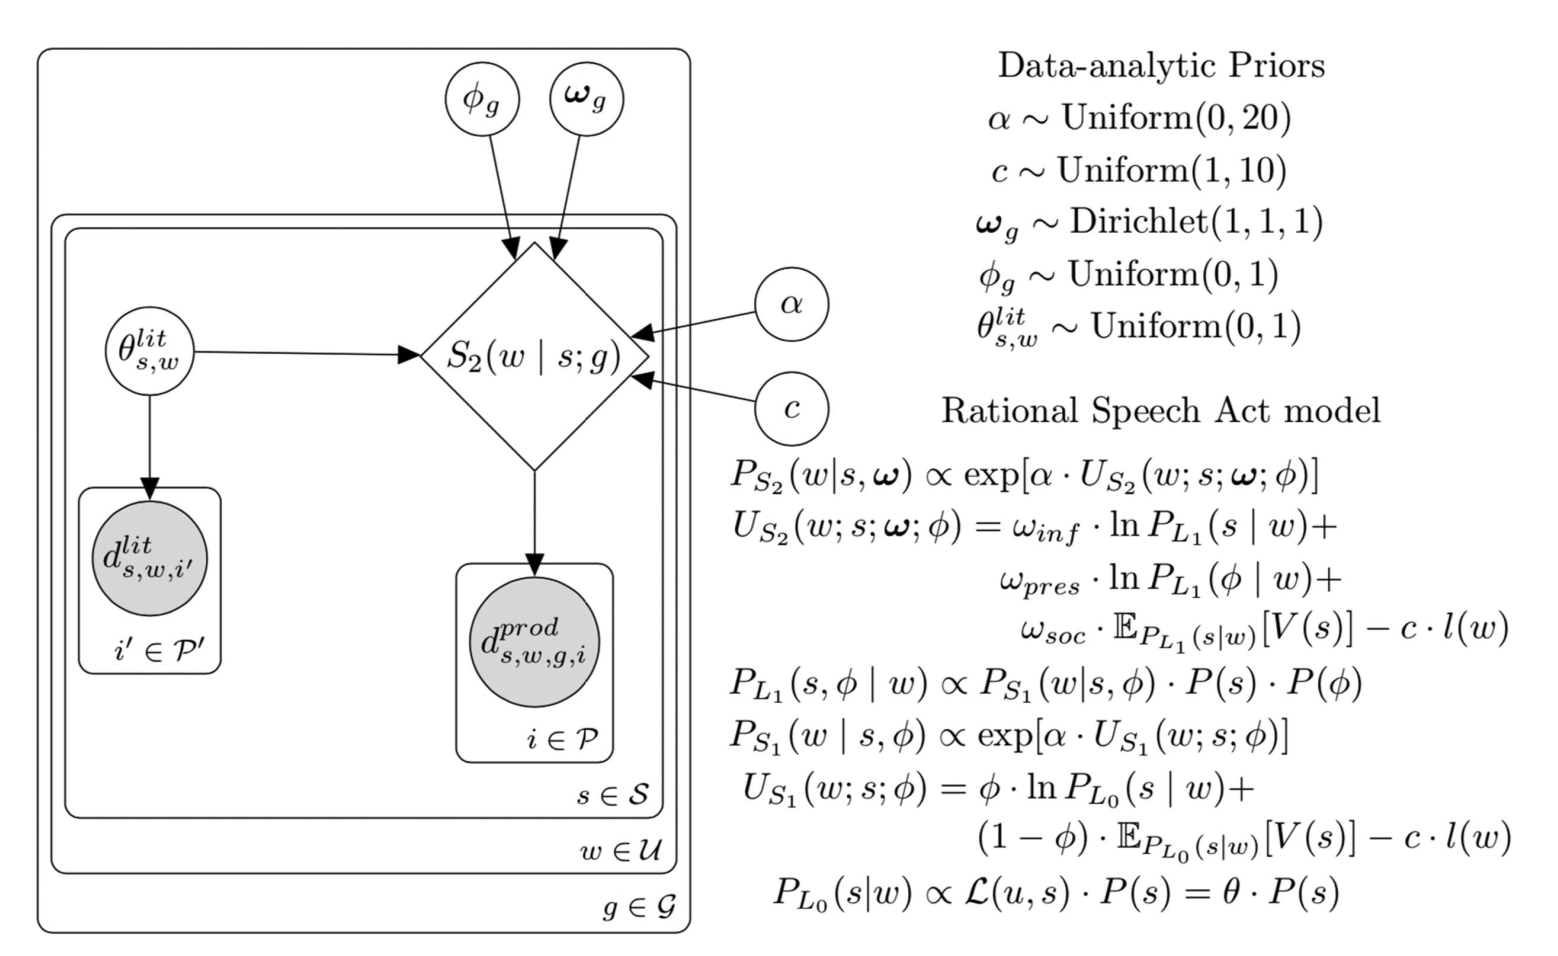

### Reproduce figure 2 with the functions

Plot $S_1$ from Figure 2:

In [302]:
reload(yoon_model_functions_pooled)

<module 'yoon_model_functions_pooled' from '/mnt/c/Users/faust/Dropbox/marieCurie/PlauDeNotes/yoon_model_functions_pooled.py'>

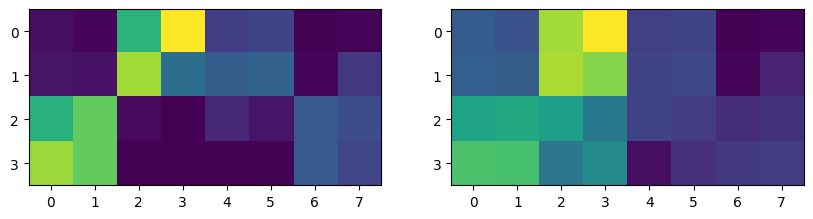

In [317]:
x = yoon_model_functions_pooled.yoon_S1(
    # values
    np.array([0, 1, 2, 3]), 
    # alpha
    1, 
    np.array([
        1,1,1,1,2,2,2,2
    ]),
    L=L,
)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.imshow(np.flipud(x[-5].T))
ax1.imshow(np.flipud(x[5].T))

Plot $L_1$ from Figure 2:

In [318]:
# Dimensions (phi, utterance, state)
L1_s_phi_given_w_grid = normalize(
    x,
    (0,2)
)

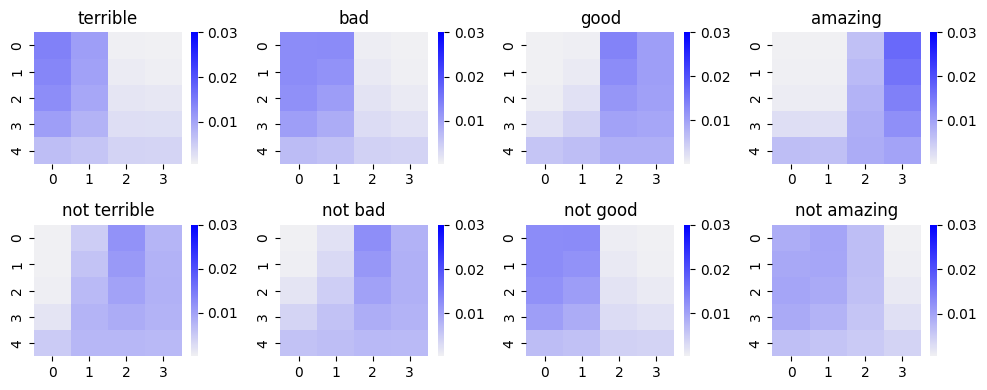

In [319]:
# bin the phi parameter into 5 bins
# and take means, to get clsoe to the figure
L1_toplot = np.stack(np.split(L1_s_phi_given_w_grid, 5)).mean(1).swapaxes(0,1)

fig, axes = plt.subplots(2,4, figsize=(10,4))
cmap = sns.color_palette("light:b", as_cmap=True)

for i, (ax, subdf, u) in enumerate(zip(axes.flatten(), L1_toplot, us)):
    sns.heatmap(
        subdf[::-1], 
        cmap=cmap,
        ax=ax,
        vmax=0.03
    )
    ax.set_title(u)
    
plt.tight_layout()

In [320]:
values =  np.array([0, 1, 2, 3])
costs = aesara.shared(np.array([
    1,1,1,1,2,2,2,2
]))

alpha = at.dscalar('alpha')
omega = at.dmatrix('omega')
phi = at.ivector('phi')

In [321]:
output = yoon_model_functions_pooled.yoon_likelihood(
    alpha, 
    values, 
    omega, 
    costs, 
    phi, 
    L,
    phi_grid_n=40
)

f_S2 = aesara.function(
    [alpha, omega, phi], 
    outputs=output
)

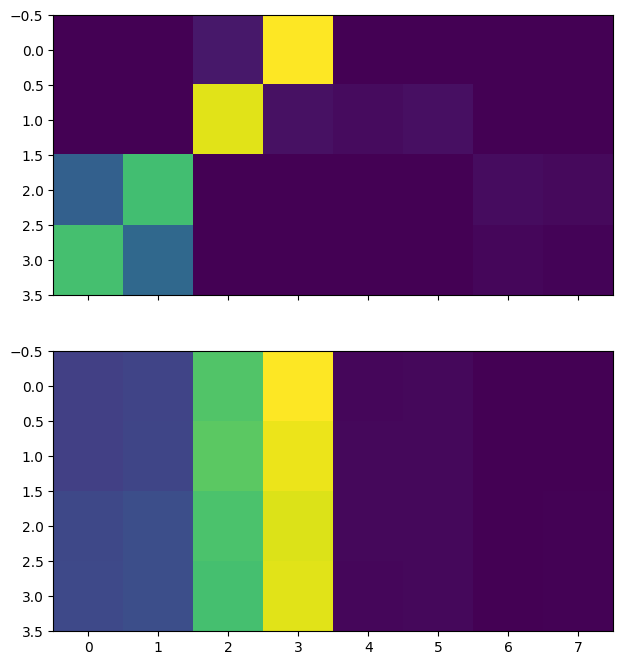

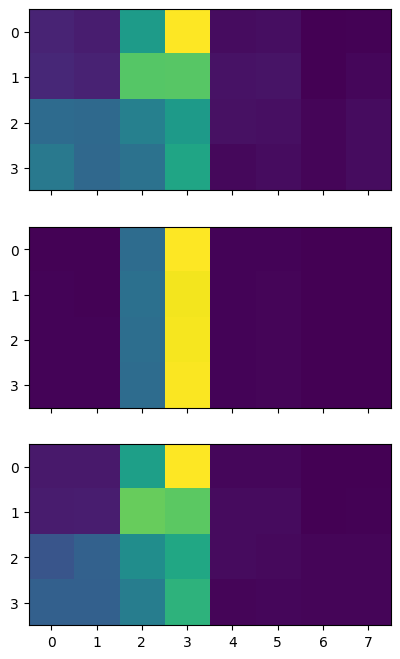

In [463]:
S2_inf, S2_soc, S2_both1, S2_both2, S2_both3 = f_S2(
    3, 
    # Weights (columns): inf, soc, pres
    [
        # informational
        [0.98, 0.01, 0.01], 
        # social
        [0.01, 0.98, 0.01],
        # presentational
        [0.1, 0.1, 0.8],
        # presentational
        [0.01, 0.01, 0.98],
        # presentational
        [0.1, 0.98, 0.1]
    ],
    # NOTE: The value of phi only matters for the 
    # presentational component of the utility
    [20, 20, 5, 0, 14]
)


fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,8))
ax1.imshow(np.flipud(S2_inf.T))
ax2.imshow(np.flipud(S2_soc.T))
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))
ax1.imshow(np.flipud(S2_both1.T))
ax2.imshow(np.flipud(S2_both2.T))
ax3.imshow(np.flipud(S2_both3.T))

[[<matplotlib.lines.Line2D at 0x7f0997735510>,

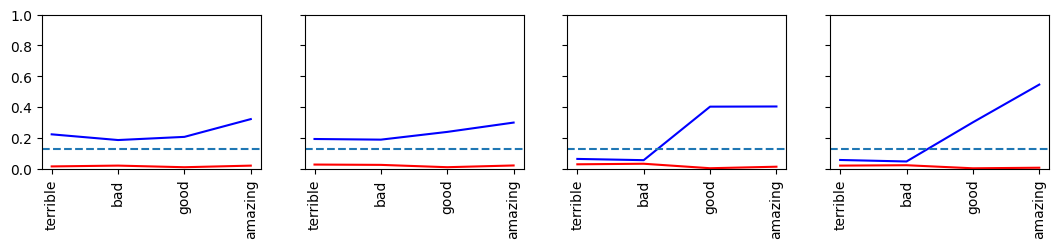

In [464]:
plot_s1(S2_both1)

In [372]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [377]:
np.eye(8)[np.array([4, 5, 2, 3])]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [385]:
[np.eye(8)[np.array([4, 5, 2, 3], dtype=int)].T, np.arange(4)]

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([0, 1, 2, 3])]

In [399]:
f_S2(
    alpha=0.5, 
    # (goal condition, utility component weight)
    omega=[[0.3, 0.3, 0.4]], 
    phi=[2]
)

array([[[0.16361841, 0.1560358 , 0.13917972, 0.13966046],
        [0.16377437, 0.15828784, 0.13941646, 0.13710931],
        [0.14670367, 0.15370407, 0.17295834, 0.17379227],
        [0.15325945, 0.1492936 , 0.17192271, 0.18283457],
        [0.08540826, 0.09814935, 0.10076828, 0.1005068 ],
        [0.09118857, 0.09456365, 0.10001378, 0.09984884],
        [0.09931191, 0.09597614, 0.08459356, 0.08318974],
        [0.09673537, 0.09398954, 0.09114714, 0.08305802]]])

In [398]:
f_S2(
    alpha=0.5, 
    # (goal condition, utility component weight)
    omega=[[0.3, 0.3, 0.4]], 
    phi=[2]
)[0,np.array([4, 5, 2, 3]),np.arange(4)]

array([0.08540826, 0.09456365, 0.17295834, 0.18283457])

In [371]:
from scipy.optimize import minimize, LinearConstraint

In [439]:
# add the constarints that omega sums to 1
contraint = LinearConstraint(
    # A is a matrix with shape (x, 3)
    # Constraint is A @ x.T
    A=np.array([1,1,1]),
    lb=1,
    ub=1
)

minimize(
    fun=lambda x: (
        -f_S2(
            alpha=0.5, 
            # (goal condition, utility component weight)
            omega=[x], 
            phi=[35]
        # get probabilities of specific utterances
        )
        [0,np.array([4, 5, 2, 3]),np.arange(4)]
        # get total probability
        .prod()
    ),
    bounds=[(0,1)]*3,
    constraints=contraint,
    x0=(0.33, 0.33, 0.34),
    tol=1e-15
)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.00026436000380132064
       x: [ 8.882e-16  1.000e+00  7.026e-17]
     nit: 15
     jac: [-3.839e-05 -5.203e-05  2.625e-05]
    nfev: 60
    njev: 15

In [429]:
-f_S2(
    alpha=0.5, 
    # (goal condition, utility component weight)
    omega=[[0.3, 0.3, 0.4]], 
    phi=[1]
# get probabilities of specific utterances
)[0,np.array([4, 5, 2, 3]),np.arange(4)].prod()

-0.0002568268245200147

### Trace plots

In [162]:
with az.rc_context(rc={'plot.max_subplots':100}):
    az.plot_pair(
        yoon_trace,
        var_names=['phi','alpha','omega']
    )
plt.savefig('posterior_correlations_yoon.png', dpi=300)
plt.close()

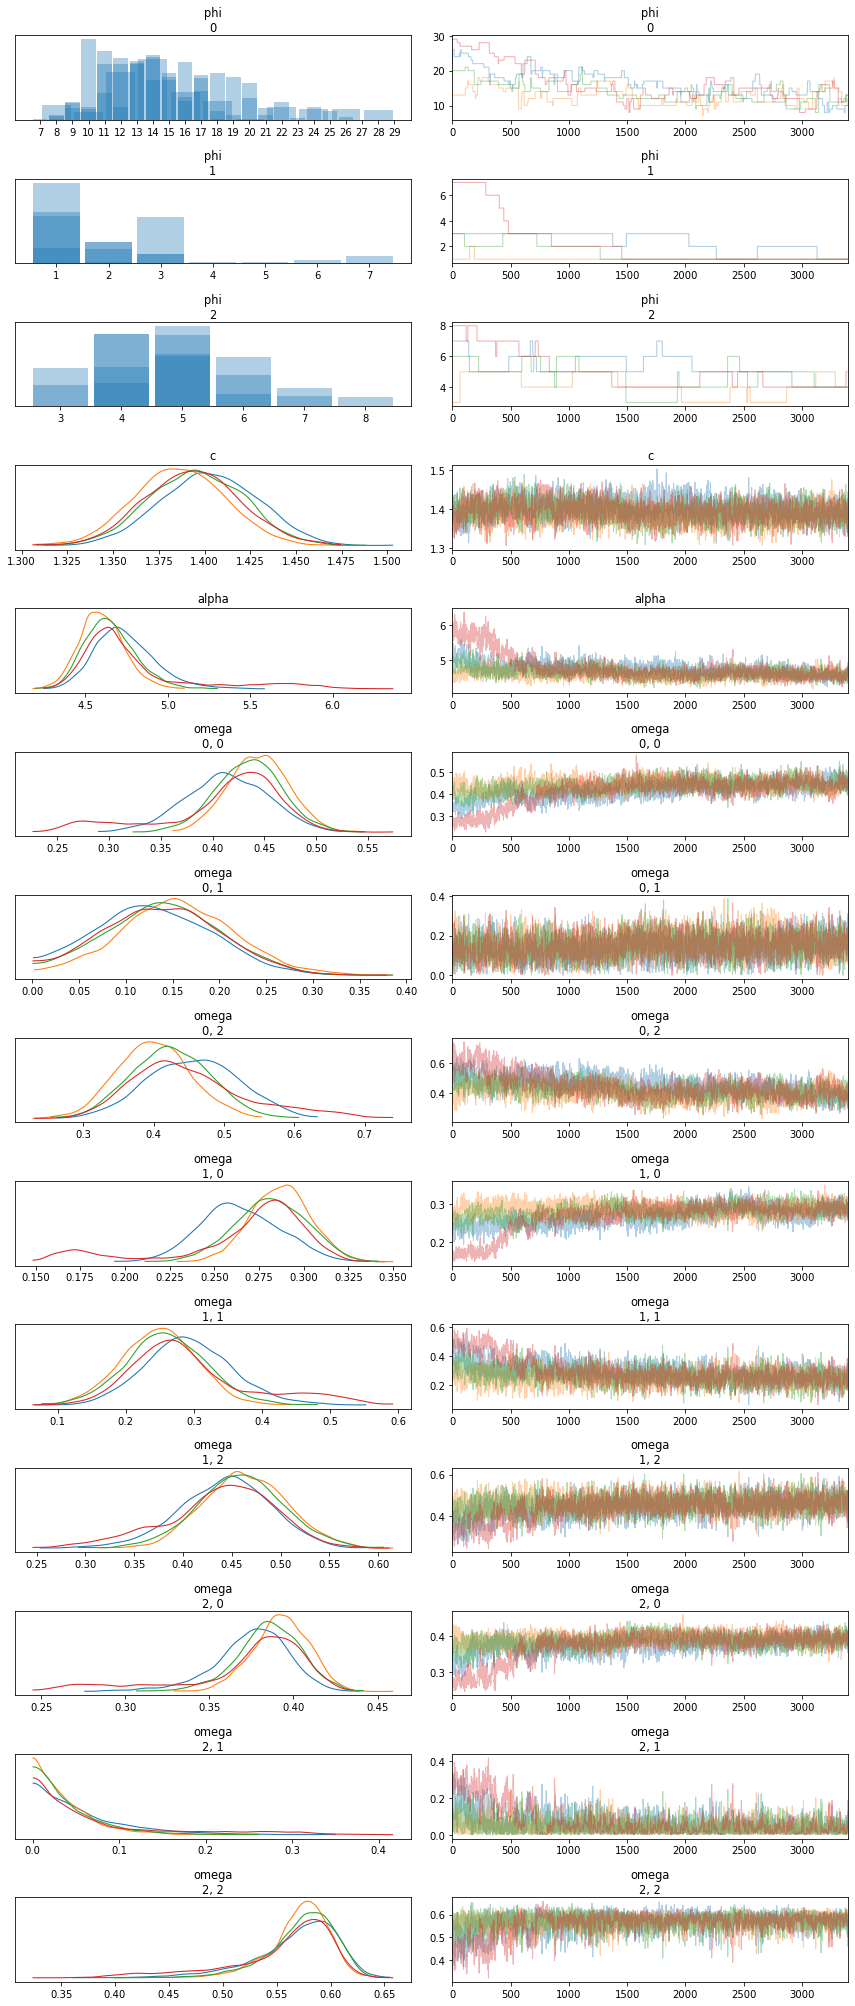

In [156]:
az.plot_trace(
    yoon_trace,
    compact=False,
    var_names="~L"
)
plt.tight_layout()
plt.show()

### Prior predictive checks

In [57]:
with yoon_model:
    yoon_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, c, chosen, omega, phi]


### Posterior predictive checks

In [157]:
with yoon_model:
    yoon_posterior_predictive = pm.sample_posterior_predictive(yoon_trace)

Sampling: [L_observed, chosen]


In [158]:
pps_yoon = yoon_posterior_predictive.posterior_predictive.chosen.values.reshape(-1,2436)

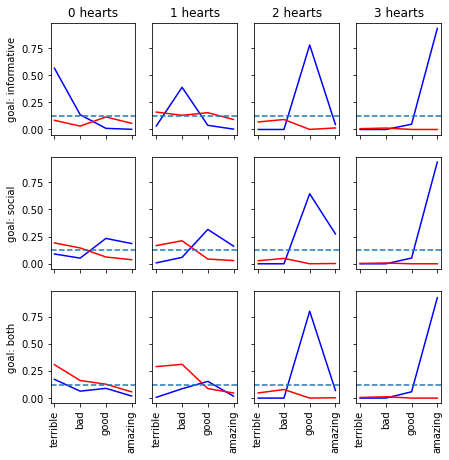

In [188]:
fig, axes = plt.subplots(
    3,4, 
    sharex=True, 
    sharey=True,
    figsize=(7,7)
)

for state in range(4):
    for goal in range(3):
        
        ax = axes[goal, state]
        
        # find proportion of each produced utterance
        # for that combination of goal and state
        subdt = (
            dt
            [(dt.true_state==state) & (dt.goal_id==goal)]
            .utterance_index
            .to_frame()
        )
        
        # posterior samples
        posterior_samples = pps_yoon[:,subdt.index].flatten()
        
        indices_us, counts = np.unique(
            posterior_samples, 
            return_counts=True
        )
        
        props = normalize(counts, 0)
        
        if len(indices_us) == 8:
            ax.plot(
                props[:4],
                color='blue'
            )
            
            ax.plot(
                props[4:],
                color='red'
            )
        ax.axhline(
            y=1/8,
            ls='--'
        )
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(us[:4], rotation=90)

[ax.set_ylabel(f'goal: {goal}') for ax,goal in zip(axes[:,0], goals)]
[ax.set_title(f'{i} hearts') for i, ax in enumerate(axes[0,:])]

# plt.show()
fig.savefig('yoon_nonhierarchical_fit.png', dpi=300)

## Hierarchical

In [95]:
yoon_model = yoon_model_functions_hierarchical.factory_yoon_model(dt, dt_meaning)

U soc:  (203, 8)
U inf:  (203, 8, 4)
U pres:  (203, 3, 8)


In [25]:
with yoon_model:
    yoon_prior_predictive = pm.sample_prior_predictive()

NameError: name 'yoon_model' is not defined

In [97]:
yoon_model.phi_ps.eval().shape

(203, 3)

In [96]:
yoon_model.phi.eval().shape

(203, 3)

In [94]:
reload(yoon_model_functions_hierarchical)

<module 'yoon_model_functions_hierarchical' from '/mnt/c/Users/faust/Dropbox/marieCurie/PlauDeNotes/yoon_model_functions_hierarchical.py'>

In [59]:
# dims: (utterance)
costs = at.concatenate((
    at.ones(4),
    at.repeat(yoon_model.c+1,4)
))

# dims: (participant, phi value, utterance, state)
S1 = yoon_model_functions_hierarchical.yoon_S1_hierarchical(
    np.array([0, 1, 2, 3]), 
    yoon_model.alpha, 
    costs, 
    yoon_model.L, 
    100, 
    lib='at'
)

In [61]:
def normalize(x, axis):
    return x / x.sum(axis=axis, keepdims=True)

# Prob of state and phi given utterance and participant
# Dimensions (participant, phi, utterance, state)
L1_s_phi_given_w_grid = normalize(
    S1,
    (1,3)
)

In [66]:
L1_s_phi_given_w_grid.eval().shape

(203, 100, 8, 4)

In [64]:
at.arange(L1_s_phi_given_w_grid.shape[0])[:,None].eval().shape

(203, 1)

In [65]:
yoon_model.phi.eval().shape

(203, 3)

In [86]:
yoon_model.phi_ps.eval().shape

(203, 3)

In [93]:
pm.Binomial.dist(
    n=99,
    p=yoon_model.phi_ps,
    shape=(203, 3)
).eval()

array([[19, 62, 76],
       [ 6, 59, 63],
       [27, 52, 66],
       [28, 46, 71],
       [75, 61, 67],
       [93, 66, 74],
       [58, 54, 82],
       [72, 57, 69],
       [43, 62, 71],
       [11, 59, 65],
       [48, 47, 71],
       [ 1, 51, 58],
       [23, 56, 71],
       [18, 56, 60],
       [61, 62, 69],
       [14, 56, 56],
       [ 7, 56, 58],
       [ 2, 50, 61],
       [ 1, 52, 65],
       [21, 60, 72],
       [ 3, 54, 61],
       [45, 42, 66],
       [13, 65, 68],
       [74, 57, 71],
       [18, 45, 62],
       [15, 62, 72],
       [87, 57, 72],
       [10, 50, 69],
       [ 2, 54, 65],
       [26, 57, 75],
       [34, 48, 69],
       [65, 53, 70],
       [10, 53, 69],
       [47, 56, 68],
       [19, 53, 66],
       [39, 59, 70],
       [ 2, 56, 62],
       [32, 59, 68],
       [98, 46, 83],
       [16, 56, 75],
       [32, 64, 61],
       [74, 53, 73],
       [88, 61, 73],
       [46, 58, 81],
       [32, 52, 73],
       [32, 62, 71],
       [73, 58, 67],
       [53, 6

In [82]:
x = L1_s_phi_given_w_grid[
    # for each participant
    at.arange(L1_s_phi_given_w_grid.shape[0])[:,None],
    # get one production array per condition
    yoon_model.phi
]

In [83]:
x.eval().shape

(203, 3, 8, 4)

In [47]:
yoon_model.phi.eval()

array([[12, 50, 69],
       [ 8, 55, 73],
       [32, 58, 60],
       [43, 57, 66],
       [68, 51, 72],
       [96, 61, 79],
       [51, 59, 71],
       [80, 50, 72],
       [34, 52, 73],
       [ 8, 63, 74],
       [50, 55, 65],
       [ 2, 53, 69],
       [24, 61, 68],
       [18, 54, 68],
       [51, 62, 72],
       [15, 65, 67],
       [ 4, 51, 62],
       [ 6, 48, 70],
       [ 2, 52, 61],
       [15, 60, 61],
       [ 2, 55, 57],
       [41, 49, 71],
       [20, 47, 67],
       [72, 63, 73],
       [23, 59, 69],
       [21, 46, 66],
       [88, 58, 65],
       [ 7, 56, 75],
       [ 3, 56, 68],
       [38, 55, 69],
       [33, 60, 69],
       [71, 50, 72],
       [ 6, 59, 60],
       [39, 53, 74],
       [22, 55, 68],
       [43, 56, 72],
       [ 1, 47, 56],
       [35, 57, 70],
       [97, 55, 83],
       [12, 57, 79],
       [29, 57, 72],
       [74, 66, 72],
       [79, 47, 74],
       [46, 50, 73],
       [39, 59, 69],
       [25, 61, 73],
       [75, 52, 79],
       [47, 6

In [ ]:
yoon_trace = az.from_netcdf(
    'traces/yoon_trace_hierarchical.cdf'
)

### Trace plots

### Posterior predictive checks

In [ ]:
for i, subdt in dt.groupby('id'):
    print(i, end=' ')
    fig, axes = plt.subplots(
        3,
        4,
        sharex=True,
        sharey=True,
        figsize=(12,4)
    )
    
    for j, subsubdt in subdt.sort_values(['goal','true_state']).groupby('goal_id'):

        for datapoint, subsubsubdt in subsubdt.iterrows():
            state = subsubsubdt['true_state']

            unique, counts = np.unique(
                pps_yoon[:,datapoint], 
                return_counts=True
            )
            axes[j][state].bar(
                unique,
                normalize(counts,0)
            )
            axes[j][state].axvline(
                subsubsubdt['utterance_index'],
                color='red'
            )
        
    axes[0][0].set_xticks(np.arange(8))
    [
        ax.set_xticklabels(us, rotation=90) 
        for ax in axes[-1]
    ]
    [
        ax.set_ylabel(goal)
        for goal, ax in zip(goals,axes[:,0])
    ]
    
    plt.tight_layout()
    
    fig.savefig(
        f'participant_posteriorpred_yoon/{i}.png',
        dpi=300
    )
    plt.close()

# My model in numpy

## Plotting functions

In [107]:
def plot_agents(utts, L0, S1, L1, fig, axes, S2=None):

    ims1 = [
        ax.imshow(L0[i])
        for i, ax in enumerate(axes[0])
    ]

    axes[0,0].set_ylabel('L0')
    axes[0,0].set_yticks(np.arange(len(utts)))
    axes[0,0].set_yticklabels(utts)

    ims2 = [
        ax.imshow(S1[i])
        for i, ax in enumerate(axes[1])
    ]

    axes[1,0].set_ylabel('S1')
    axes[1,0].set_yticks(np.arange(len(utts)))
    axes[1,0].set_yticklabels(utts)

    ims3 = [
        ax.imshow(L1[i])
        for i, ax in enumerate(axes[2])
    ]

    axes[2,0].set_ylabel('L1')
    axes[2,0].set_yticks(np.arange(len(utts)))
    axes[2,0].set_yticklabels(utts)
    
    [
        ax.set_title(s) 
        for ax, s in 
        zip(axes[0], ['Disparaging', 'Informative', 'Laudatory'])
    ]
    
    if S2 is not None:
        
        ims4 = [
            ax.imshow(S2[i])
            for i, ax in enumerate(axes[2])
        ]

        axes[2,0].set_ylabel('S2')
        axes[2,0].set_yticks(np.arange(len(utts)))
        axes[2,0].set_yticklabels(utts)

        return ims1, ims2, ims3, ims4
    
    return ims1, ims2, ims3

In [176]:
def plot_s1(S1, axes=None):
    # %matplotlib inline

    if axes is None:
        fig, axes = plt.subplots(
            1,
            len(values), 
            sharey=True,
            figsize=(13,2)
        )

    plotslist = []
    # loop over states
    for i, ax in enumerate(axes):

        line = S1[:,i]
        tbga = line[:4]
        n_tbga = line[4:]
        plot1 = ax.plot(
            tbga,
            color='blue'
        )[0]
        plot2 = ax.plot(
            n_tbga,
            color='red'
        )[0]

        plotslist.append([plot1, plot2])
        
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(
            ['terrible', 'bad', 'good', 'amazing'],
            rotation=90
        )

        ax.axhline(
            y=1/8, 
            linestyle='--'
        )

        ax.set_ylim(0,1)
        
    return plotslist

## Implementation

Intuition with this model:
- If I see a bad state and I am trying to be polite, I can pretend to be in a different state. This choice is affected by
    1. How much I gain by pretending to be in the better state. E.g. 'terrible'->'bad' is a bigger gain than 'good'->'excellent'
    2. How implausible it is to pretend to be in that state
- These two considerations may vary between participants!
- Given a pretend-state (which can also be the true state), I then select a signal
    - The signal tends to maximize the expected social utility
- Therefore, in this model social utility plays double duty: in deciding whether to pretend to be in a different state than one is, and in selecting a signal given the pretend-state.

In [114]:
def calculate_s1(values, 
                 likestate_utterance_compatibility, 
                 s1_rationality, 
                 verosimilitude, 
                 pretend_temp,
                 S1_weights):
    
    Xs, Zs = np.indices((5,5))
    costs = np.array([1,1,1,1,2,2,2,2])
    
    ##### Polite speaker
    
    # given each true state, probability that the speaker 
    # will pretend to be in each other state
    # to balance social value and verosimilitude
    p_pretend = normalize(
        np.exp(pretend_temp*(
            # given true state (row), value of pretending to be in another state (col)
            # For each true observation and utterance,
            # the value of pretending to be in each observation
            # given the social value and the acceptability for the judge
                # Kindness!
                # Tend to pretend to be in a positive state
                (1-verosimilitude)*values
                # Verosimilitude!
                # tend to not depart from truth (judge)
                # (is punished for departures from truth)
                # Uses exponential decay
                - verosimilitude*(np.abs(Xs - Zs)**2)
        )),
        1
    )
    
    # literal listener
    L0 = normalize(
        likestate_utterance_compatibility,
        1
    )

    # expected social value of each utterance
    # given literal listener interpretation
    # Shape (utterance, state)
    expected_social_value = masked_mean(
        # social value of each state
        values
        # probability of each value 
        # given each utterance,
        # for the literal listener
        * L0,
        likestate_utterance_compatibility
    )

    S1 = normalize(
        np.exp(s1_rationality*(
            S1_weights[0]*expected_social_value
            # tends to be informative
            + S1_weights[1]*np.log(
                # likestate_utterance_compatibility
                L0
            )
            - S1_weights[2]*costs[:,None]
        )),
        0
    )

    # shape: true state, pretend state, signal
    # Contains the joint probability, for each true state,
    # of the participant pretending to be in each state
    # AND sending a certain signal in that pretend state
    y = p_pretend[:,:,None] * S1.T

    # sum over pretend states 
    # to get marginal probability
    # (across pretend states)
    # of signal given true state
    S1_polite = y.sum(1).T
    
    return S1_polite

In [115]:
us = [
    'terrible',
    'bad',
    'good',
    'amazing',
    'not terrible',
    'not bad',
    'not good',
    'not amazing'
]

likestate_utterance_compatibility = np.array([
    # terrible
    [1, 0, 0, 0, 0],
    # bad
    [1, 1, 0, 0, 0],
    # good
    [0, 0, 0, 1, 1],
    # excellent
    [0, 0, 0, 0, 1],
    # not terrible
    [0, 1, 1, 1, 1],
    # not bad
    [0, 0, 1, 1, 1],
    # not good
    [1, 1, 1, 0, 0],
    # not excellent
    [1, 1, 1, 1, 0]
])


In [167]:
# assuming that the first dimension 
# is the true value 
values = np.array([-10., -5., 0., 3., 5.])

s1_polite = calculate_s1(
    values, 
    likestate_utterance_compatibility, 
    s1_rationality=2., 
    verosimilitude=0.7,
    pretend_temp=2.,
    # (soc, inf, cost)
    S1_weights=normalize(np.array([1,1,1]),0),
)

/tmp/ipykernel_703/2373854506.py:57: RuntimeWarning: divide by zero encountered in log
  + S1_weights[1]*np.log(


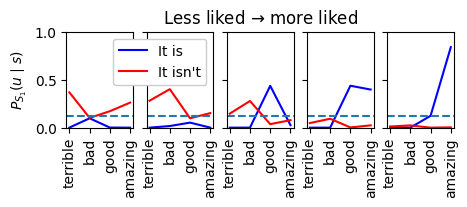

In [229]:
fig, axes = plt.subplots(1,5, figsize=(5,2), sharey=True)
plots = plot_s1(s1_polite, axes)
# plt.tight_layout()
axes[1].legend(
    plots[0], 
    ['It is', "It isn't"], 
    loc='upper left',
    framealpha=1.,
    # edgecolor='white',
    bbox_to_anchor=(-0.6, 0.5, 0.5, 0.5)
)

axes[2].set_title(r'Less liked $\to$ more liked')

axes[0].set_ylabel(r'$P_{S_1} (u \mid s)$')
plt.subplots_adjust(bottom=0.4)
fig.savefig('figures/mymodelExample.png', dpi=300)

## Plots

In [449]:
for i in range(100): plt.close()

/tmp/ipykernel_269/3916259777.py:61: RuntimeWarning: divide by zero encountered in log
  np.log(


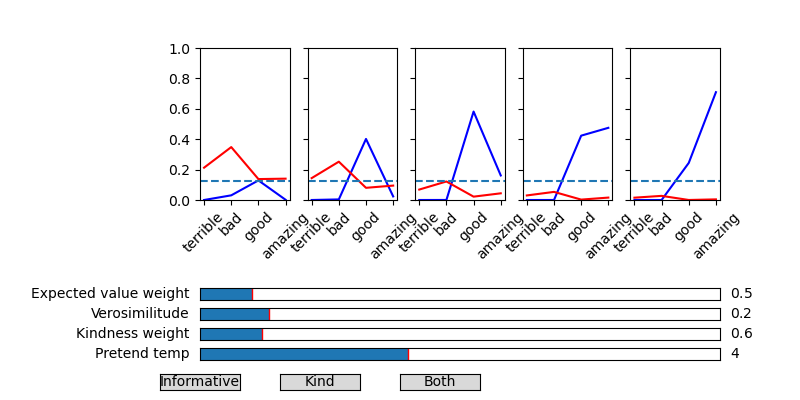

In [17]:
%matplotlib widget

##### Initial values

values = np.array([-8., -2., 0., 1., 1.5])

s1_rationality = 1.4
expected_value_weight = 0.5
verosimilitude = 0.2
kindness_weight = 0.6
pretend_temp = 4

s1_polite = calculate_s1(
    values, 
    likestate_utterance_compatibility, 
    s1_rationality=s1_rationality,
    pretend_temp=pretend_temp,
    kindness_weight=kindness_weight,
    verosimilitude=verosimilitude,
    expected_value_weight=expected_value_weight,
)

fig, axes = plt.subplots(
    1,
    len(values), 
    sharey=True,
    figsize=(8,4)
)

lines = plot_s1(s1_polite, axes)
    
# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.5)

# Make a horizontal slider 
ax1 = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider1 = Slider(
    ax=ax1,
    label='Pretend temp',
    valmin=0.,
    valmax=10,
    valinit=pretend_temp,
)

ax2 = fig.add_axes([0.25, 0.15, 0.65, 0.03])
slider2 = Slider(
    ax=ax2,
    label=r'Kindness weight',
    valmin=0.,
    valmax=5,
    valinit=kindness_weight,
)

ax3 = fig.add_axes([0.25, 0.2, 0.65, 0.03])
slider3 = Slider(
    ax=ax3,
    label=r'Verosimilitude',
    valmin=0.,
    valmax=1.5,
    valinit=verosimilitude,
)

ax4 = fig.add_axes([0.25, 0.25, 0.65, 0.03])
slider4 = Slider(
    ax=ax4,
    label=r'Expected value weight',
    valmin=0.,
    valmax=5,
    valinit=expected_value_weight,
)

def update_plot(s1_polite):
    
    # one tuple of lines for each 
    for i, (p1,p2) in enumerate(lines):
        
        # get the 5 lines for that signal
        line = s1_polite[:,i]
        
        tbga = line[:4]
        n_tbga = line[4:]

        p1.set_data(
            np.arange(4),
            tbga
        )
        p2.set_data(
            np.arange(4),
            n_tbga
        )
    
    img.autoscale()
    fig.canvas.draw_idle()
    

# The function to be called anytime a slider's value changes
def update(val):

    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=slider1.val,
        kindness_weight=slider2.val,
        verosimilitude=slider3.val,
        expected_value_weight=slider4.val,
    )
    
    update_plot(s1_polite)
    

# register the update function with each slider
slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)

# # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
# def reset(event):
#     slider1.reset()
#     slider2.reset()
#     slider3.reset()
#     slider4.reset()
#     slider5.reset()

# button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
# button = Button(button_ax, 'Reset', hovercolor='0.975')    
# button.on_clicked(reset)

def set_informative(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=6,
        kindness_weight=0.6,
        verosimilitude=0.2,
        expected_value_weight=0.5,
    )
    
    update_plot(s1_polite)

set_informative_ax = fig.add_axes([0.2, 0.025, 0.1, 0.04])
button_informative = Button(set_informative_ax, 'Informative', hovercolor='0.975')    
button_informative.on_clicked(set_informative)


def set_kind(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=1.6,
        kindness_weight=0.37,
        verosimilitude=0.02,
        expected_value_weight=2.8,
    )
    update_plot(s1_polite)

set_kind_ax = fig.add_axes([0.35, 0.025, 0.1, 0.04])
button_kind = Button(set_kind_ax, 'Kind', hovercolor='0.975')    
button_kind.on_clicked(set_kind)


def set_both(event):
    s1_polite = calculate_s1(
        values, 
        likestate_utterance_compatibility, 
        s1_rationality=s1_rationality,
        pretend_temp=10,
        kindness_weight=0.1,
        verosimilitude=0.03,
        expected_value_weight=4,
    )
    update_plot(s1_polite)

set_both_ax = fig.add_axes([0.5, 0.025, 0.1, 0.04])
button_both = Button(set_both_ax, 'Both', hovercolor='0.975')    
button_both.on_clicked(set_both)

plt.show()

Params for informative condition:
- weight_polite = 0.1
- expected value weight = 0.5
- verosimilitude = 0.2
- kindness_weight = 0.6
- pretend_temp = 6

Params for kind condition:
- weight_polite = 0.82
- expected value weight = 2.8
- verosimilitude = 0.02
- kindness_weight = 0.37
- pretend_temp = 1.6
Although for top state, 'amazing' is produced less than data

Params for both condition:
- weight_polite = 0.7
- expected value weight = 4
- verosimilitude = 0.03
- kindness_weight = 0.1
- pretend_temp = 10

# Fit my model to data

In [466]:
model = my_model_functions.my_model_factory(dt)

In [465]:
trace_mymodel = trace.from_netcdf("traces/trace_mymodel.cdf")

In [19]:
with model:
    var_fit = pm.fit()

Finished [100%]: Average Loss = 3,842.7


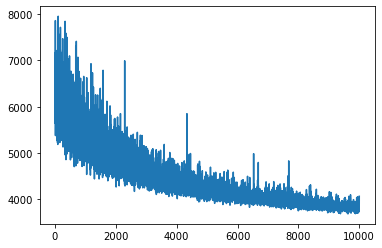

In [22]:
plt.plot(var_fit.hist)

## Trace plots

In [472]:
print(model.str_repr())

     s1_rationality ~ Exp(f())
  verosim_condition ~ N(0, 1)
      verosim_sigma ~ N**+(0, 1)
         verosim_zs ~ N(0, 1)
       pretend_temp ~ Exp(f())
S1_weight_condition ~ N**+(0, 1)
    S1_weight_sigma ~ N**+(0, 1)
       S1_weight_zs ~ N**+(0, 1)
         S1_weights ~ Dir(f(S1_weight_condition, S1_weight_zs, S1_weight_sigma))
             values ~ N(0, 5)
     verosimilitude ~ Deterministic(f(verosim_condition, verosim_sigma, verosim_zs))
  chosen_utterances ~ Cat(f(s1_rationality, pretend_temp, values, S1_weights, verosim_condition, verosim_sigma, verosim_zs))


/home/fausto/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (3681) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'verosim_condition\n0'}>,
        <AxesSubplot: title={'center': 'verosim_condition\n1'}>,
        <AxesSubplot: title={'center': 'verosim_condition\n2'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n0'}>],
       [<AxesSubplot: title={'center': 'verosim_zs\n1'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n2'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n3'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n4'}>],
       [<AxesSubplot: title={'center': 'verosim_zs\n5'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n6'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n7'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n8'}>],
       [<AxesSubplot: title={'center': 'verosim_zs\n9'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n10'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n11'}>,
        <AxesSubplot: title={'center': 'verosim_zs\n12'}>],
       [<AxesSubplot: title={'center': 'vero

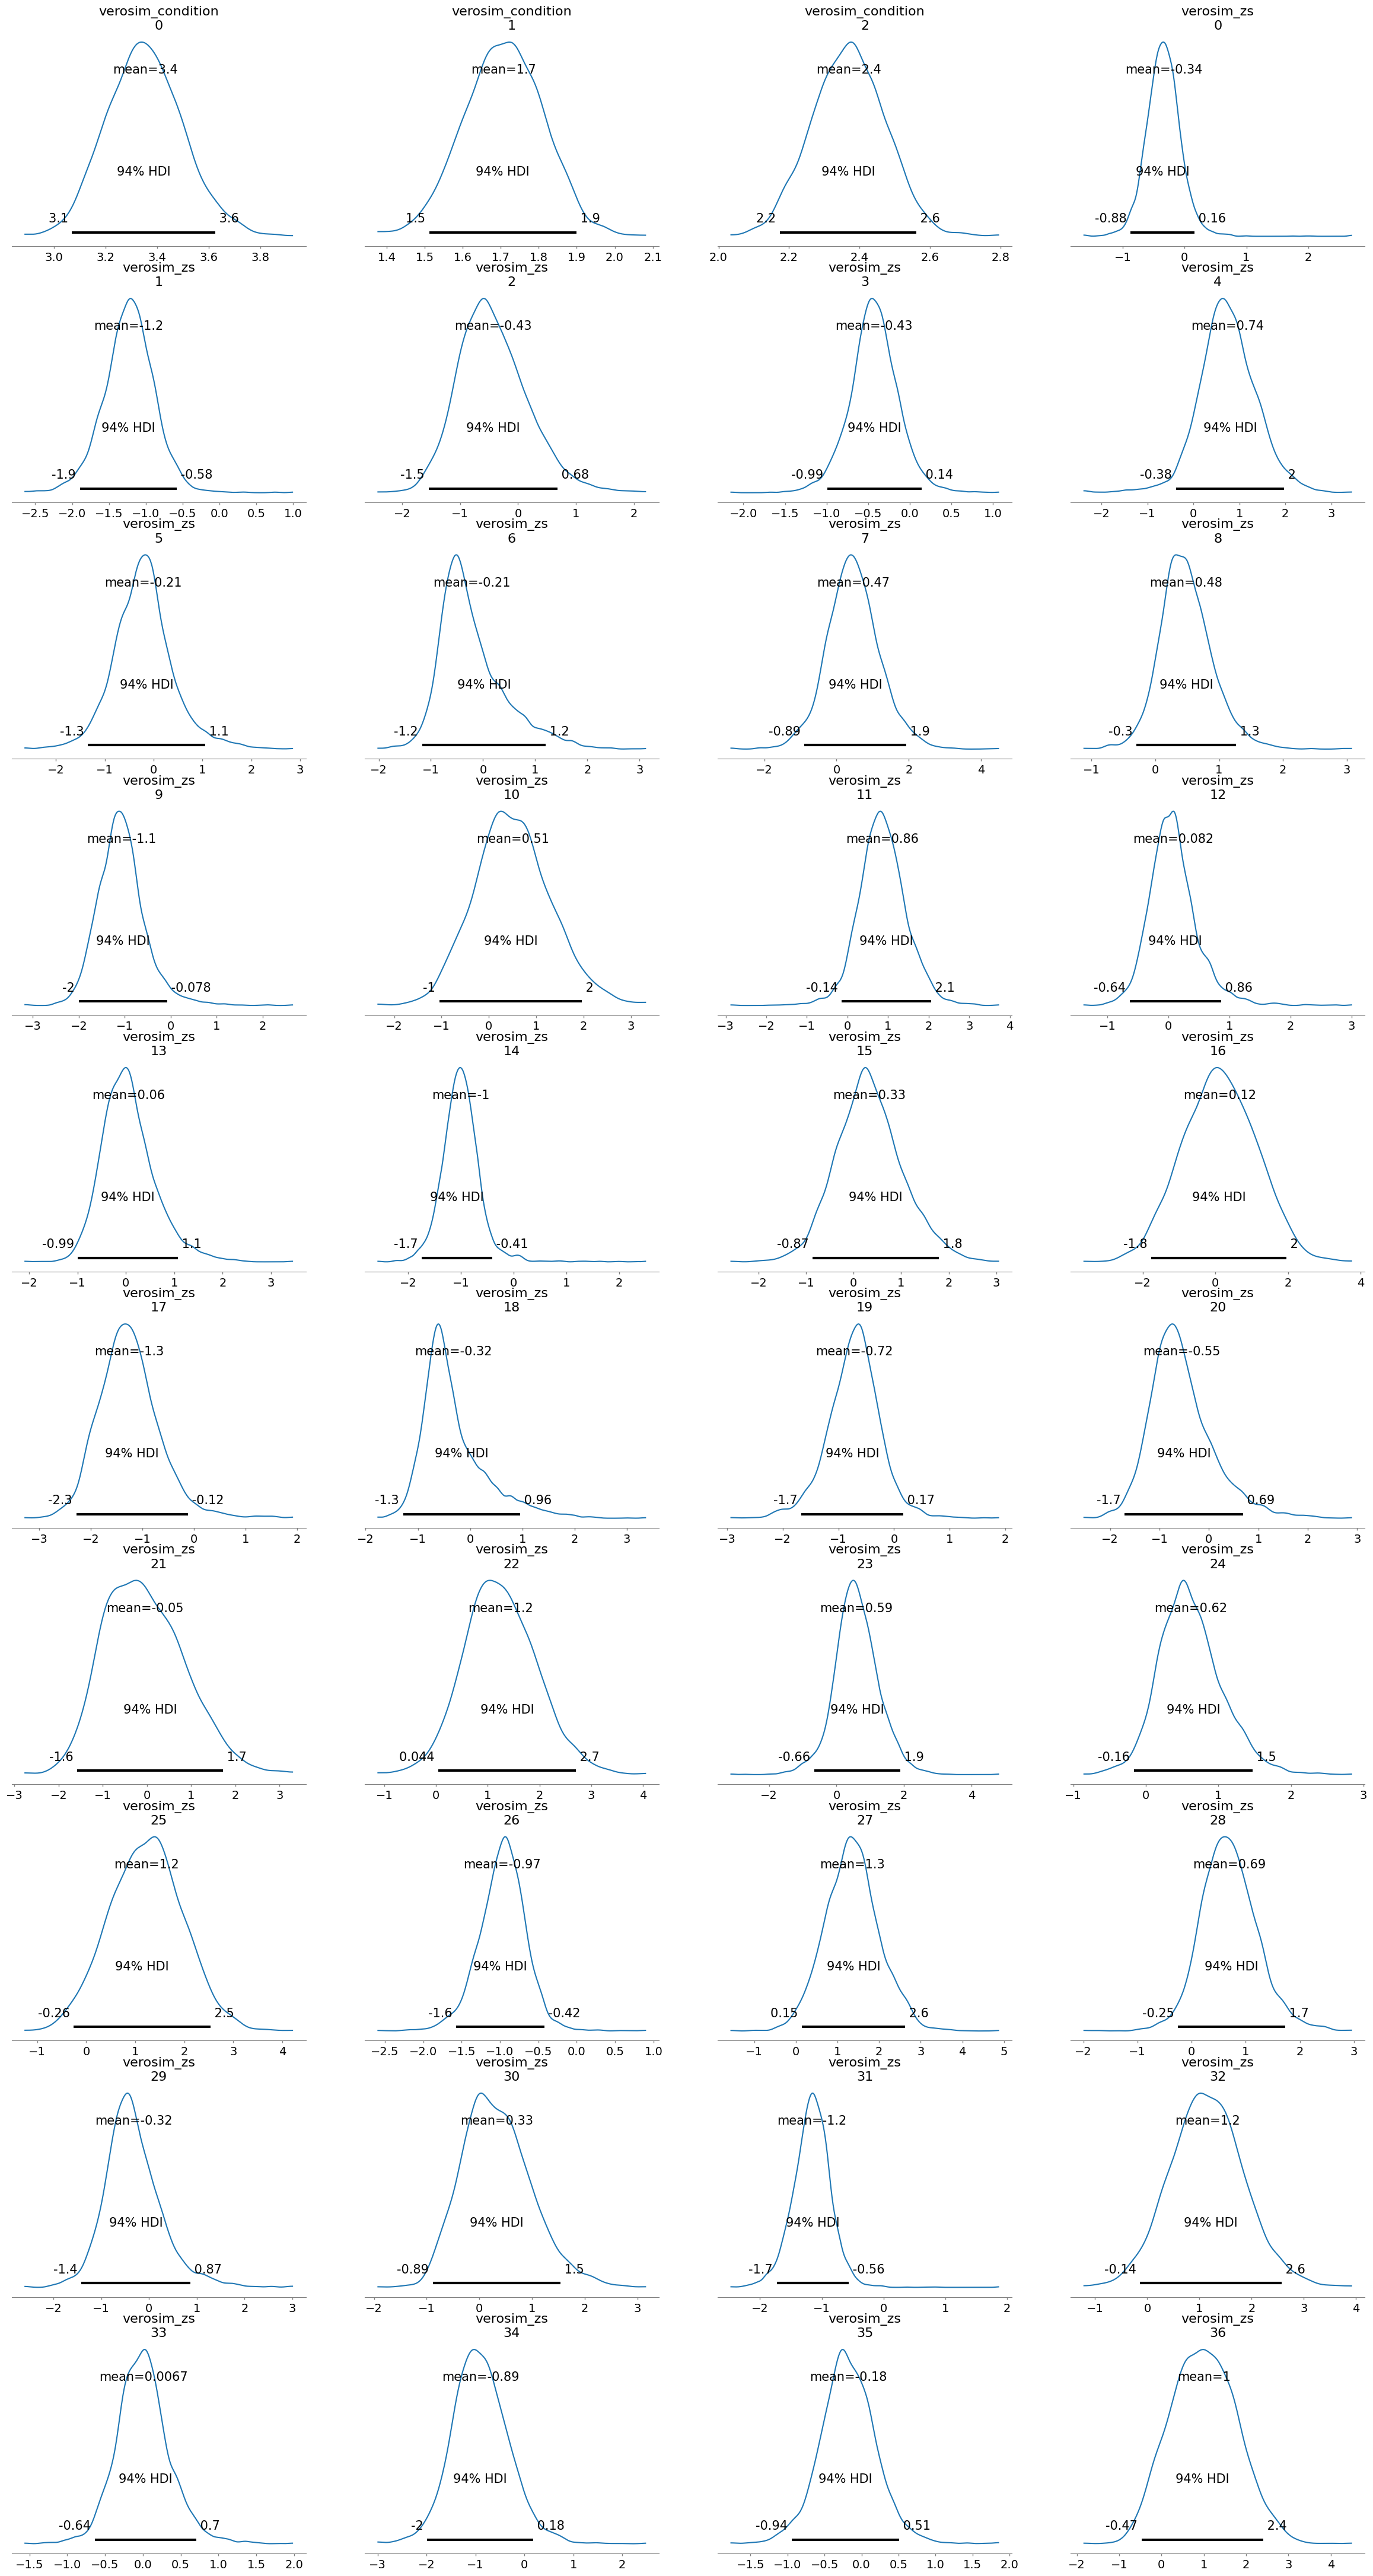

In [468]:
az.plot_posterior(trace_mymodel)

In [467]:
az.plot_trace(trace_mymodel)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f0a05d0cc10> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0a1ef11900> (for post_execute):



KeyboardInterrupt



/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (609), generating only 20 plots
  warnings.warn(


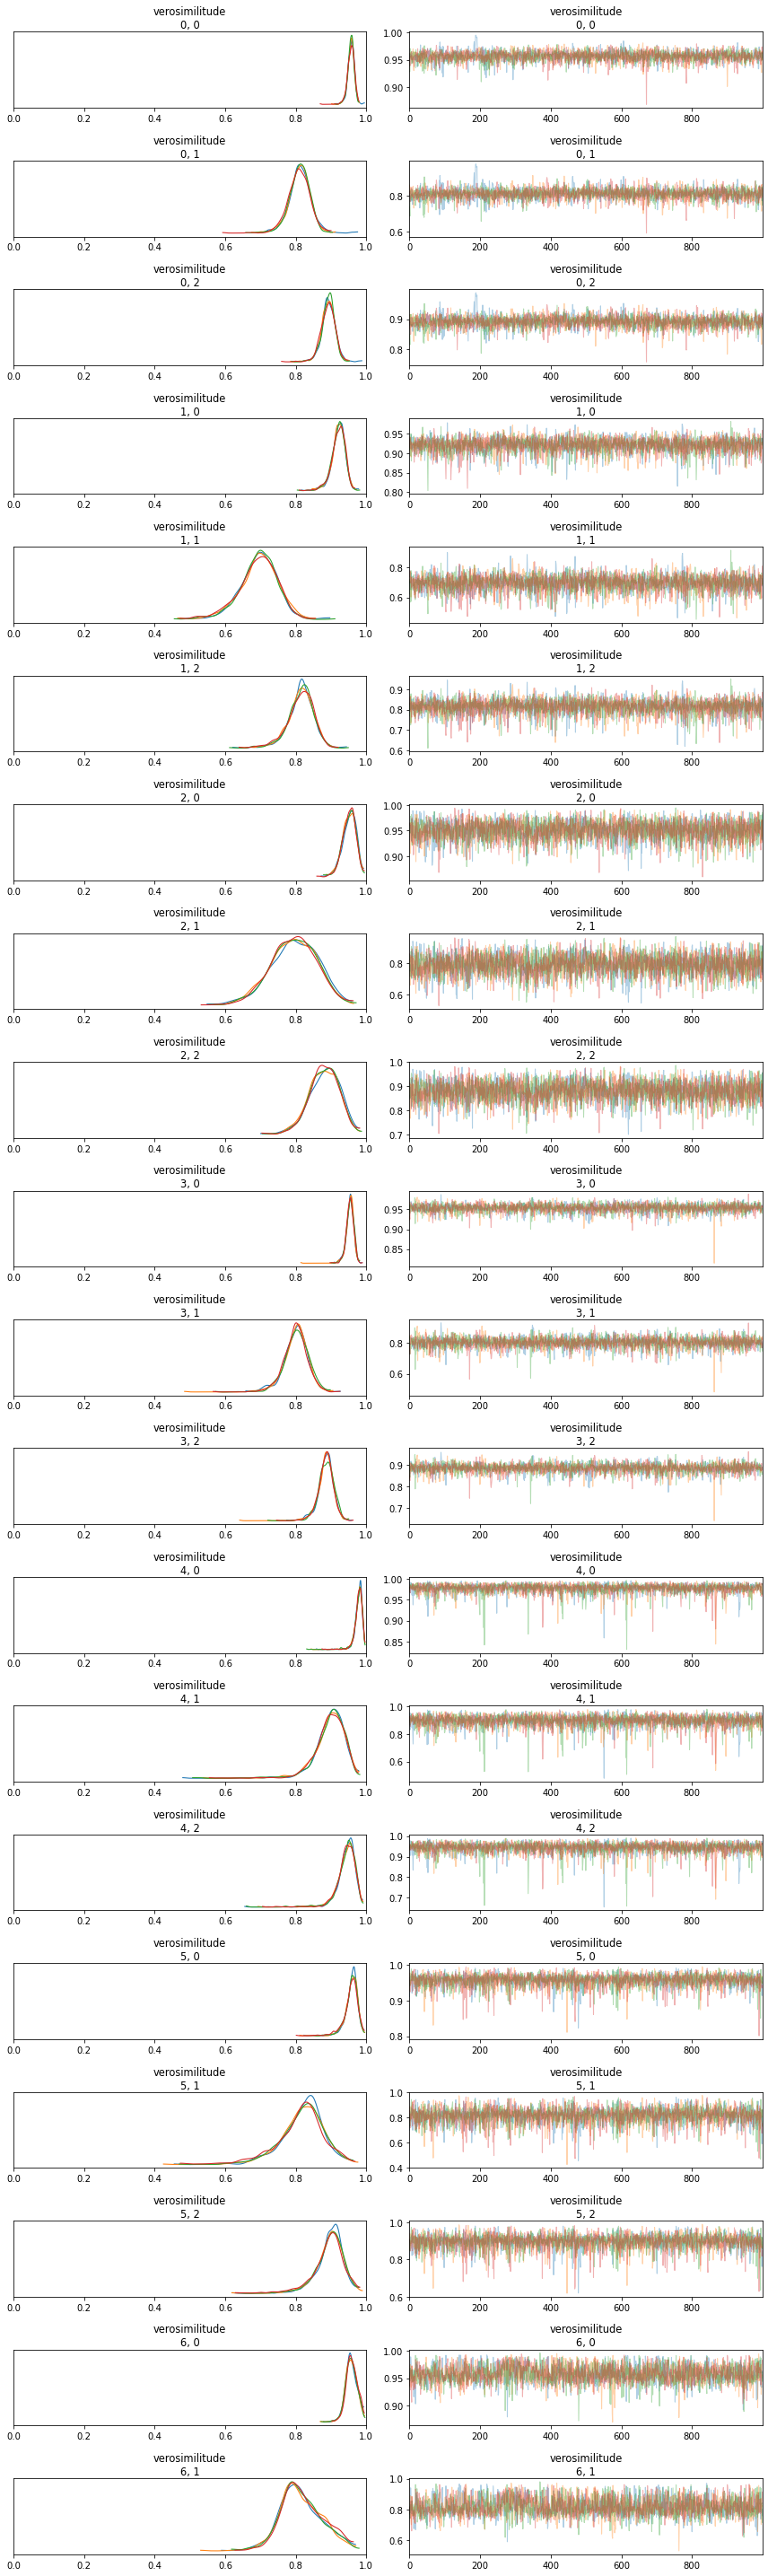

In [66]:
axes = az.plot_trace(
    trace, 
    var_names='verosimilitude', 
    compact=False,
)

[ax.set_xlim(0,1) for ax in axes[:,0]]

plt.tight_layout()
plt.show()

## Posterior predictive

In [67]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

Sampling: [chosen_utterances]


In [68]:
posterior_predictive_same_observed = (
    posterior_predictive
    .posterior_predictive
    .chosen_utterances
    .values == dt.utterance_index.values
)

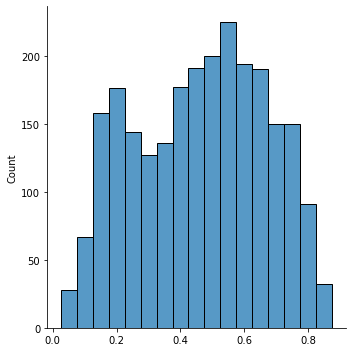

In [69]:
sns.displot(
    posterior_predictive_same_observed.mean((0,1)), 
)

In [70]:
dt.loc[:,'mean_posterior_right'] = posterior_predictive_same_observed.mean((0,1))

In [71]:
dt.groupby(['goal','true_state'])['mean_posterior_right'].mean()

goal         true_state
both         0             0.322546
             1             0.347074
             2             0.527170
             3             0.635951
informative  0             0.381738
             1             0.283078
             2             0.462259
             3             0.600711
social       0             0.393719
             1             0.439246
             2             0.496866
             3             0.666676
Name: mean_posterior_right, dtype: float64

In [72]:
pps = posterior_predictive.posterior_predictive.chosen_utterances.values.reshape(-1, 2436)

In [73]:
for i, subdt in dt.groupby('id'):
    print(i, end=' ')
    fig, axes = plt.subplots(
        3,
        4,
        sharex=True,
        sharey=True,
        figsize=(12,4)
    )
    
    for j, subsubdt in subdt.sort_values(['goal','true_state']).groupby('goal_id'):

        for datapoint, subsubsubdt in subsubdt.iterrows():
            state = subsubsubdt['true_state']

            unique, counts = np.unique(
                pps[:,datapoint], 
                return_counts=True
            )
            axes[j][state].bar(
                unique,
                normalize(counts,0)
            )
            axes[j][state].axvline(
                subsubsubdt['utterance_index'],
                color='red'
            )
        
    axes[0][0].set_xticks(np.arange(8))
    [
        ax.set_xticklabels(us, rotation=90) 
        for ax in axes[-1]
    ]
    [
        ax.set_ylabel(goal)
        for goal, ax in zip(goals,axes[:,0])
    ]
    
    plt.tight_layout()
    
    fig.savefig(
        f'participant_posteriorpred_mymodel/{i}.png',
        dpi=300
    )
    plt.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 

## Prior predictive

In [12]:
with model:
    prior_samples = pm.sample_prior_predictive()

Sampling: [S1_weight_condition, S1_weight_sigma, S1_weight_zs, S1_weights, chosen_utterances, pretend_temp, s1_rationality, values, verosim_condition, verosim_sigma, verosim_zs]


In [13]:
prior_samples

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

# Model comparison

In [26]:
yoon_loo = az.loo(yoon_trace, var_name='chosen')

In [27]:
mymodel_loo = az.loo(trace_mymodel)

/home/fausto/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [32]:
trace_mymodel

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [28]:
mymodel_loo

Computed from 4000 posterior samples and 2436 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2703.76    39.01
p_loo      505.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1946   79.9%
 (0.5, 0.7]   (ok)        348   14.3%
   (0.7, 1]   (bad)       130    5.3%
   (1, Inf)   (very bad)   12    0.5%

In [33]:
trace_trace_mymodel.log_likelihood.rename(chosen_utterances='chosen')

<xarray.Dataset>
Dimensions:                  (chain: 4, draw: 1000, chosen_utterances_dim_0: 1,
                              chosen_utterances_dim_1: 2436)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * chosen_utterances_dim_0  (chosen_utterances_dim_0) int64 0
  * chosen_utterances_dim_1  (chosen_utterances_dim_1) int64 0 1 2 ... 2434 2435
Data variables:
    chosen                   (chain, draw, chosen_utterances_dim_0, chosen_utterances_dim_1) float64 ...
Attributes:
    created_at:                 2022-12-30T19:42:03.067264
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [40]:
compare = az.compare(
    compare_dict={
        'Truth stretching': trace_mymodel
        .rename({'chosen_utterances':'chosen'}),
        'Yoon': yoon_trace
    },
    var_name='chosen'
)

/home/fausto/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


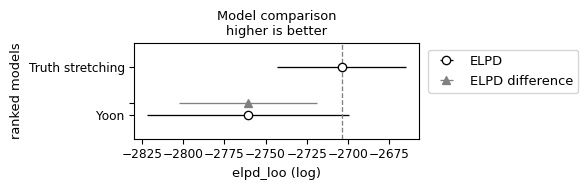

In [43]:
az.plot_compare(compare)
plt.tight_layout()
plt.savefig(
    'figures/yoon_vs_truthstretching.png', 
    dpi=300
)

# Experiments with integration

In [87]:
import jax
from jax import jit

In [97]:
from scipy.integrate import quad, quad_vec
from pytensor.graph.op import Op
from pytensor.graph.basic import Apply
from pytensor import clone_replace

In [96]:
class Integrate(Op):
    
    def __init__(self, jax_func, start, stop, outputshape):
        """
        
        outputshape can be (None,) or ()
        if the function returns a vector or a float respectively
        """

        super().__init__()
        
        self._func = jax.jit(jax_func)
        self._start = start
        self._stop = stop
        self.outputshape = outputshape
        
    def make_node(self, *extra_vars):

        self._extra_vars_node = [
            at.as_tensor_variable(ex)
            for ex in extra_vars
        ]

        return Apply(
            # op: The operation that produces `outputs` given `inputs`.
            op=self, 
            # inputs: The arguments of the expression modeled by the `Apply` node.
            inputs=list(self._extra_vars_node), 
            # outputs: The outputs of the expression modeled by the `Apply` node.
            # NOTE: This is a scalar if self._expr is a scalar,
            # and a vector if self._expr is a vector. Etc.
            outputs=[at.TensorType(
                dtype=np.float64, 
                shape=self.outputshape, 
                name='integrand'
            )()]
        )
    
    def perform(self, node, inputs, out):

        if len(self.outputshape) == 0:
            val = quad(
                self._func, 
                self._start, 
                self._stop, 
                args=tuple(inputs),
                # epsabs=1e-5
            )[0]
            
        elif len(self.outputshape) == 1:
            # if the function is vector-valued
            # (e.g., the gradient of a vector),
            # use quad_vec
            val = quad_vec(
                self._func,
                self._start,
                self._stop,
                args=tuple(inputs),
                # epsabs=1e-5
            )[0]
        else:
            # first reshape into an array
            shape = self._func(
                self._start,
                *args
            ).shape
            
            def helpfunc(*args):
                return self._func(*inputs).flatten()
            
            # put back into original shape
            val = quad_vec(
                helpfunc,
                self._start,
                self._stop,
                args=tuple(inputs),
                # epsabs=1e-5
            )[0].reshape(shape)
        
        # in-place modification of "out".
        # out is a single-element list
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        
        # unpack the input
        out, = grads

        # calculate the SYMBOLIC gradient of self._expr
        # wrt each extra variable.
        # This can be done because they're symbolic aesara variables!
        # This corresponds to the gradient of the expression
        # *inside* the integral (the inner part of Leibniz'
        # integral rule)
        grads = at.jacobian(
            # cost
            self._expr, 
            # wrt
            self._extra_vars
        )
        
        dargs = []
        # loop over the gradients of the extra vars
        for grad in grads:
            
            # define an Apply node
            # for that gradient
            integrate = Integrate(
                # integrate gradient
                grad, 
                # wrt to same variable as 
                # main expression
                self._var, 
                *self._extra_vars
            )
            
            jacobian = integrate(
                start, stop, 
                *args
            )
            
            darg = at.dot(
                jacobian.T, 
                out
            )
            
            dargs.append(darg)

        return dargs
    
    

    
# The VJPCustomOp only needs `make_node` and `perform`.
class VJPIntegrateOp(Op):
    
    def __init__(self, jax_func):
        
        def vjp_integrate_op_jax(inputs, output_grads):
            _, vjp_fn = jax.vjp(integrate_op_jax, inputs)
            return vjp_fn(output_grads)

        jitted_vjp_integrate_op_jax = jax.jit(vjp_integrate_op_jax)
        self.jitted
    
    def make_node(self, output_gradients, **extra_vars):
        # Make sure the two inputs are tensor variables
        inputs = [
            pt.as_tensor_variable(output_gradients), 
            pt.as_tensor_variable(x)
        ]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, output_gradients) = inputs
        (result,) = jitted_vjp_custom_op_jax(x, output_gradients)
        outputs[0][0] = np.asarray(result, dtype="float64")
        
    
integrate = Integrate(
    jax_func,
    start,
    stop
)

vjp_integrate = VJPIntegrateOp()

NameError: name 'Op' is not defined

In [88]:
def jax_func(t, a, b):
    return t**a + b

In [89]:
jitted_func = jit(jax_func)

In [93]:
jitted_func.

<CompiledFunction of <function jax_func at 0x7f09d466b1c0>>

In [ ]:
y_obs = np.array([8.3, 8.0, 7.8])
start = 1.
stop = 2.

with pm.Model() as basic_model:

    a = pm.Uniform(
        'a', 
        1.5, 
        3.5
    )
    b = pm.Uniform(
        'b', 
        4., 
        6., 
        shape=(3)
    )

    integrate = Integrate(
        jitted_func,
        start,
        stop
    )

    # Now we plug in the values from the model.
    # The `a_` and `b_` from above corresponds 
    # to the `a` and `b` here.
    mu = integrate(
        a, 
        b
    )

    y = pm.Normal(
        'y', 
        mu=mu, 
        sigma=0.4, 
        observed=y_obs
    )

with basic_model:
    trace = pm.sample(
        1500, 
        tune=500, 
        cores=2, 
        chains=2,
        return_inferencedata=True
    )